# Práctica  Escenarios de Estrés y Cambios de Régimen

## Objetivo (resumen)
Construir un motor interpretable de detección de regímenes (calma/crisis) y simulación multiactivo con cópulas,
capaz de generar escenarios de estrés y cuantificar pérdidas extremas (VaR 99% y ES/CVaR 99%).

## Datos

Se explora el movimiento diario, desde 2006-01-01 hasta hoy, de los siguientes activos:
- High Yield: HYG
- Bonos gobierno USA 10Y y 2Y (proxies líquidos): IEF (7–10Y Treasury) y SHY (1–3Y Treasury)
- Mercado (proxy para gráficos/regímenes): SPY (S&P 500)
- Yields DGS10 y DGS2 (FRED) como indicadores de tipos


Fuentes:
- Precios ajustados (acciones/ETFs): Yahoo Finance (via `yfinance`)
- Series macro/crediticias (yields y spread HY): FRED (via `pandas_datareader`)


In [66]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as st
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from datetime import datetime, timezone
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler

In [67]:
# Tickers a usar
tickers = [
    "GLD",
    "HYG",   # High Yield ETF (precio/retornos)
    "IEF",
    "SHY" # proxis líquidos para UST 10Y y 2Y (aprox.)
]

In [68]:
SEED = 42
np.random.seed(SEED)
FROM = "2006-01-01"
TO = datetime.now().date().isoformat()

# Anhadimos SPY
tickers.append("SPY") # mercado (S&P500)

# Series FRED (indicadores interpretables)
fred_series = {
    "DGS10": "UST_10Y_YIELD",          # 10Y yield
    "DGS2":  "UST_2Y_YIELD",           # 2Y yield
    "BAMLH0A0HYM2": "HY_OAS_SPREAD"    # spread HY
}

px = yf.download(
    tickers,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

fred = pdr.DataReader(list(fred_series.keys()), "fred", FROM, TO)
fred = fred.rename(columns=fred_series)

# Eliminamos los dias que no haya precio (no bursatil)
px = px.dropna(axis=0, how="all")
fred = fred.dropna(axis=0, how="all")

# Eliminamos los tickers que no tengan precio
px = px.dropna(axis=1, how="all")
fred = fred.dropna(axis=1, how="all")

returns = np.log(px).diff().dropna()
closed_prices = pd.concat([px.add_prefix("PX_"), fred.add_prefix("FRED_")], axis=1)

print("Rango (Dias Bursatiles):", px.index.min().date(), "-", px.index.max().date())
print("Precios descargados:", px.shape[1], "activos |", list(px.columns))
print("FRED descargado:", fred.shape[1], "series |", list(fred.columns))
print("Retornos (log) shape:", returns.shape)
display(closed_prices)

Rango (Dias Bursatiles): 2006-01-03 - 2026-02-11
Precios descargados: 5 activos | ['GLD', 'HYG', 'IEF', 'SHY', 'SPY']
FRED descargado: 3 series | ['UST_10Y_YIELD', 'UST_2Y_YIELD', 'HY_OAS_SPREAD']
Retornos (log) shape: (4740, 5)


,PX_GLD,PX_HYG,PX_IEF,PX_SHY,PX_SPY,FRED_UST_10Y_YIELD,FRED_UST_2Y_YIELD,FRED_HY_OAS_SPREAD
2006-01-03,53.119999,NaN,49.726410,55.632374,87.463272,4.37,4.34,3.73
2006-01-04,53.299999,NaN,49.815281,55.687786,87.877472,4.36,4.31,3.69
2006-01-05,52.340000,NaN,49.827129,55.639301,87.932693,4.36,4.32,3.64
2006-01-06,53.720001,NaN,49.761944,55.653175,88.664421,4.38,4.36,3.56
2006-01-09,54.599998,NaN,49.785633,55.660095,88.892212,4.38,4.36,3.51
...,...,...,...,...,...,...,...,...
2026-02-05,441.880005,80.529999,96.070000,82.860001,677.619995,4.21,3.47,2.97
2026-02-06,455.459991,80.809998,96.070000,82.860001,690.619995,4.22,3.50,2.87
2026-02-09,467.029999,80.919998,96.089996,82.879997,693.950012,4.22,3.48,2.84
2026-02-10,462.399994,80.839996,96.510002,82.930000,692.119995,4.16,3.45,2.86


En esta práctica se utilizan ETFs líquidos (por ejemplo, SPY, IEF, SHY, GLD y HYG) como proxies de los activos financieros subyacentes
(renta variable, bonos gubernamentales, oro y crédito high yield).
La elección responde a criterios de **liquidez y coherencia económica**.

Los ETFs proporcionan **precios diarios ajustados**, negociados en mercado continuo, lo que permite construir retornos homogéneos
y comparables entre activos desde 2006 sin problemas de iliquidez o falta de observaciones.
Esto es especialmente relevante en el caso de la renta fija, donde los bonos individuales no cotizan diariamente y presentan
problemas de precios “stale”.

Además, los ETFs reflejan de forma agregada el comportamiento de su clase de activo
(p. ej. SPY para el mercado accionario estadounidense o IEF/SHY para la curva de tipos),
lo que los hace adecuados para el análisis de **regímenes de mercado y escenarios de estrés**.
De este modo, se prioriza la estabilidad estadística del dataset y la interpretabilidad económica de los resultados.


# Fase 1 — Detección de regímenes con Gaussian HMM (2 estados)

Modelizamos el “pulso” del mercado asumiendo que existen **dos regímenes latentes**: *calma* y *crisis*.
Para estimarlos, ajustamos un **Gaussian Hidden Markov Model (HMM)** con **2 estados** sobre una matriz de retornos diarios
(multiactivo), de forma que el modelo aprenda:

- La **distribución** de retornos típica en cada estado (media y covarianza).
- La **dinámica temporal** (probabilidad de permanecer en el estado o cambiar al otro).

Una vez entrenado, inferimos para cada día el estado más probable y lo **representamos sobre el S&P 500 (SPY)**,
coloreando el fondo: **Blanco = Calma**, **Azul = Crisis**.


In [69]:
############################# Configuracion para el modelo #############################

RV1 = 20          # RV corto (estrés agudo) -> cada 20 dias
D_MACRO = 20      # cambios "mensuales" para FRED (evita ruido semanal)
N_STATES = 2
N_ITER = 3000

SMOOTH = 40      # suavizado de prob. crisis
THR = 0.6       # umbral de crisis
MIN_LEN = 30     # duración mínima (en días) para aceptar un episodio
GAP_TOL = 15     # Si hay GAP_TOL dias entre crisis entendemos que es una falsa alarma y que seguimos en crisis

In [70]:

date_all_with_price = closed_prices.isna().any(axis=1)
start_date = date_all_with_price[date_all_with_price == False].index.min()

feat = pd.DataFrame(index=closed_prices.index)

# Mercado
feat["SPY_ret"] = returns["SPY"]
# Volatilidad movil anualizada
feat[f"SPY_RV{RV1}"] = returns["SPY"].rolling(RV1).std() * np.sqrt(252)

# Crédito (cambios, no niveles)
fred_hy = closed_prices["FRED_HY_OAS_SPREAD"].ffill()
feat[f"dHY_OAS_{D_MACRO}d"] = fred_hy.diff(D_MACRO)

# Tipos (cambios en pendiente, no nivel)
y10 = closed_prices["FRED_UST_10Y_YIELD"].ffill()
y2  = closed_prices["FRED_UST_2Y_YIELD"].ffill()

# Diferencia de rentabilidad entre los bonos de largo plazo y los de corto plazo
slope = (y10 - y2)
feat[f"dSLOPE_{D_MACRO}d"] = slope.diff(D_MACRO)

if "IEF" in returns.columns:
    feat["IEF_ret"] = returns["IEF"]
if "GLD" in returns.columns:
    feat["GLD_ret"] = returns["GLD"]

# Quitamos NaNs
feat = feat.loc[feat.index >= start_date].dropna()

In [71]:
# Winsorización, percentil 1 y 99
for c in feat.columns:
    lo, hi = feat[c].quantile([0.01, 0.99])
    feat[c] = feat[c].clip(lo, hi)

In [72]:
print("HMM: ", feat.index.min().date(), " - ", feat.index.max().date())
print("Features:", list(feat.columns))

# feat -> Camapana de Gauss
Z = StandardScaler().fit_transform(feat.values)

hmm = GaussianHMM(n_components=N_STATES, covariance_type="full", n_iter=N_ITER, random_state=SEED)
hmm.fit(Z)

crisis_prediction = pd.Series(hmm.predict(Z), index=feat.index, name="states")
crisis_probability = pd.DataFrame(hmm.predict_proba(Z), index=feat.index, columns=[0, 1])

# Etiquetar crisis con criterio económico (vol alta + spread widening + peor retorno)
results = pd.DataFrame({
    "SPY_ret_mean": feat["SPY_ret"].groupby(crisis_prediction).mean(),
    f"SPY_RV{RV1}_vol": feat[f"SPY_RV{RV1}"].groupby(crisis_prediction).mean(),
    "dHY_ret_mean": feat[f"dHY_OAS_{D_MACRO}d"].groupby(crisis_prediction).mean()
})

crisis_state = results[f"SPY_RV{RV1}_vol"].idxmax()

print("Transmat:", hmm.transmat_)
print("Crisis_state:", crisis_state)
print("Resumen por estado:")
results

HMM:  2007-05-09  -  2026-02-11
Features: ['SPY_ret', 'SPY_RV20', 'dHY_OAS_20d', 'dSLOPE_20d', 'IEF_ret', 'GLD_ret']
Transmat: [[0.9868511  0.0131489 ]
 [0.02082498 0.97917502]]
Crisis_state: 1
Resumen por estado:


,SPY_ret_mean,SPY_RV20_vol,dHY_ret_mean
states,,,
0,0.000673,0.106538,-0.106411
1,-0.000027,0.251493,0.160706


In [73]:
# Score: estrés = vol alta + subida de spread + retorno medio más bajo
scores = results[f"SPY_RV{RV1}_vol"] + results["dHY_ret_mean"].clip(lower=0) - results["SPY_ret_mean"]
print("Scores:\n", scores)

Scores:
 states
0    0.105865
1    0.412226
dtype: float64


In [74]:
def build_episodes(stress: pd.Series, min_len=15, gap_tol=5):
    dates = stress.index.to_numpy()
    stress_values = stress.astype(int).values

    # 0 + [episodios estres] + 0 -> Permite que veamos cambios por si empezamos o terminamos en crisis
    changes = np.diff(np.r_[0, stress_values, 0])
    starts = np.where(changes == 1)[0]
    ends   = np.where(changes == -1)[0]  # exclusivo

    episodes = []
    for a, b in zip(starts, ends):
        if (b - a) >= min_len:
            episodes.append([a, b])

    if not episodes:
        return []

    merged = [episodes[0]]
    for a, b in episodes[1:]:
        pa, pb = merged[-1]
        if (a - pb) <= gap_tol:
            merged[-1][1] = b
        else:
            merged.append([a, b])

    return [(dates[a], dates[b-1]) for a, b in merged]

In [75]:
p_crisis = crisis_probability[crisis_state]
p_crisis_smooth = p_crisis.rolling(SMOOTH).mean()

crisis = (p_crisis_smooth > THR).astype(int)
episodes = build_episodes(crisis, min_len=MIN_LEN, gap_tol=GAP_TOL)
print("N episodios:", len(episodes))
for episode in episodes:
    print(np.datetime_as_string(episode[0], unit='D'), " - ", np.datetime_as_string(episode[1], unit='D'))

N episodios: 11
2007-08-27  -  2007-10-12
2007-12-05  -  2010-01-15
2010-06-07  -  2010-10-15
2011-09-01  -  2012-02-02
2015-09-23  -  2015-11-05
2016-01-07  -  2016-04-18
2018-03-09  -  2018-05-03
2018-11-15  -  2019-02-25
2020-03-26  -  2020-12-23
2022-03-03  -  2023-03-01
2025-04-10  -  2025-06-20


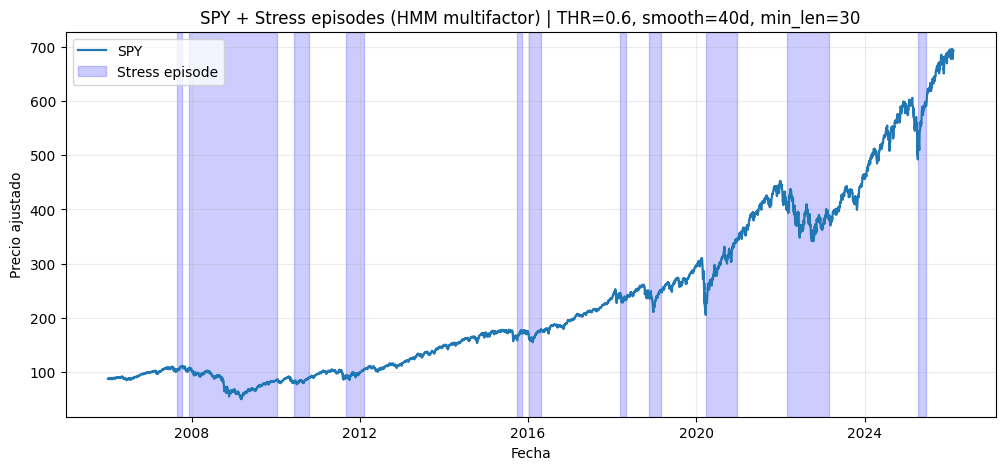

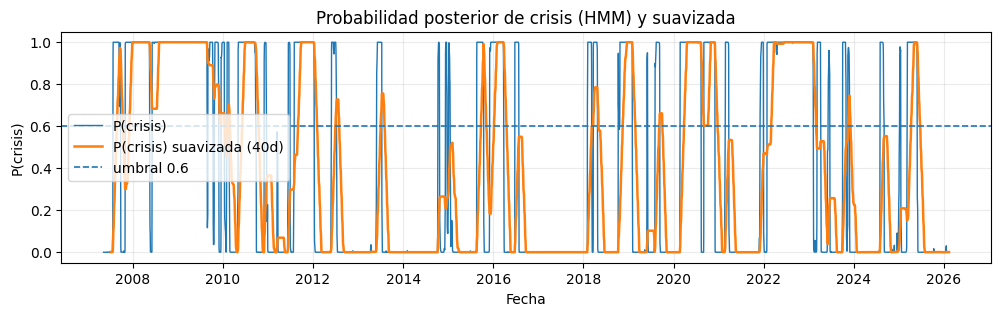

In [76]:
spy_plot = px["SPY"] #.reindex(feat_clip.index).ffill()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(spy_plot.index, spy_plot.values, linewidth=1.6, label="SPY")

for (a, b) in episodes:
    ax.axvspan(a, b, alpha=0.20, color="blue", label="Stress episode")

# leyenda sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc="upper left")

ax.set_title(f"SPY + Stress episodes (HMM multifactor) | THR={THR}, smooth={SMOOTH}d, min_len={MIN_LEN}")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio ajustado")
ax.grid(True, alpha=0.25)
plt.show()

# Plot de probabilidad (diagnóstico)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(p_crisis.index, p_crisis, linewidth=1.0, label="P(crisis)")
ax.plot(p_crisis_smooth.index, p_crisis_smooth, linewidth=1.8, label=f"P(crisis) suavizada ({SMOOTH}d)")
ax.axhline(THR, linestyle="--", linewidth=1.2, label=f"umbral {THR}")
ax.set_title("Probabilidad posterior de crisis (HMM) y suavizada")
ax.set_xlabel("Fecha")
ax.set_ylabel("P(crisis)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

# Fase 2 — Anatomía del Riesgo 

En esta fase cuantificamos cómo cambian las distribuciones **individuales** de los retornos cuando el mercado pasa de *calma* a *crisis*.

Para cada activo calculamos, **condicional a cada estado** (Estado 0 = Calma, Estado 1 = Crisis):
- **Media** (retorno esperado diario)
- **Volatilidad** (desviación típica diaria)
- **Skewness** (asimetría)
- **Kurtosis (exceso)** (colas: >0 indica colas más pesadas que normal)

Además, respondemos:
1) ¿Cuánto aumenta la volatilidad de **HYG** al pasar de Estado 0 a Estado 1?  
2) ¿Sigue siendo **GLD** un activo refugio? (lo evaluamos por su media/vol en crisis y, como extra, su correlación con SPY en crisis).


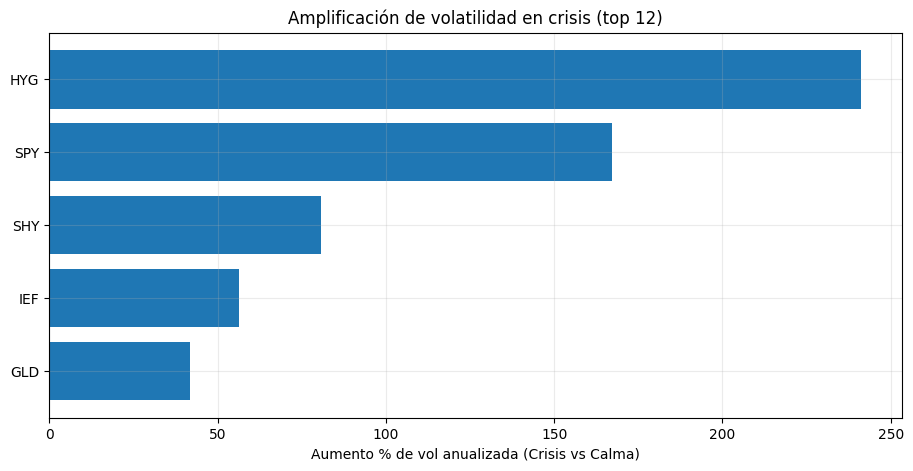

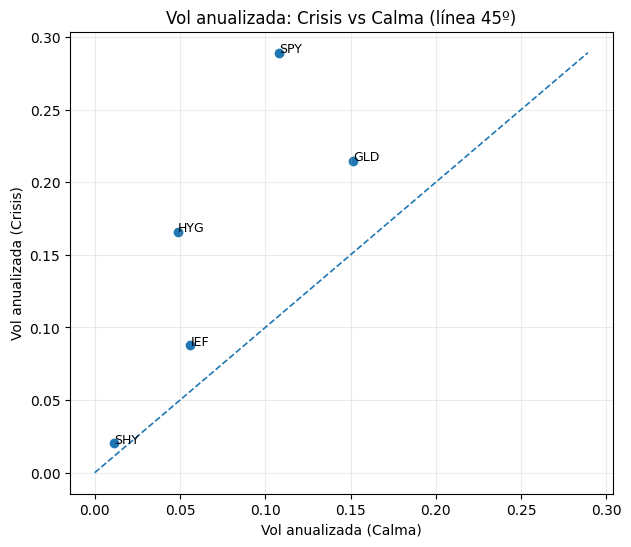

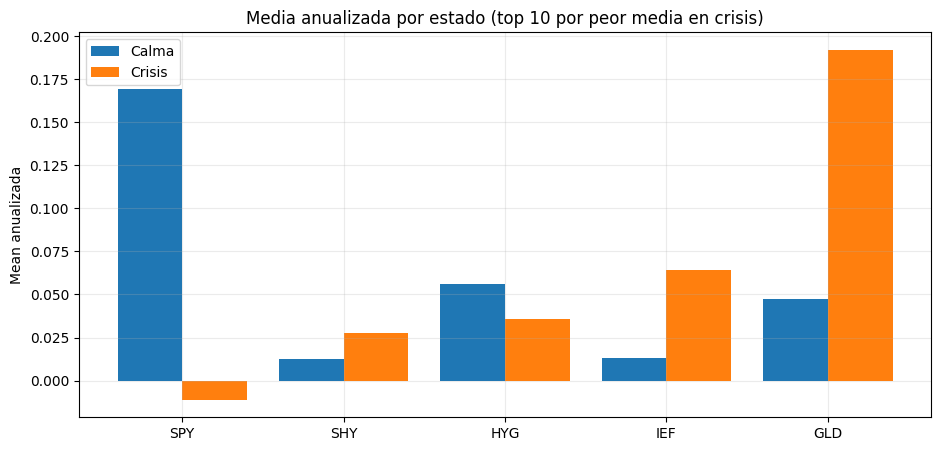

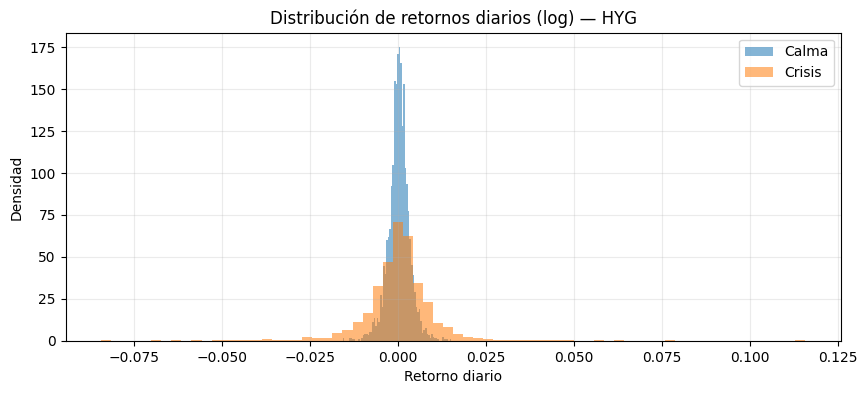

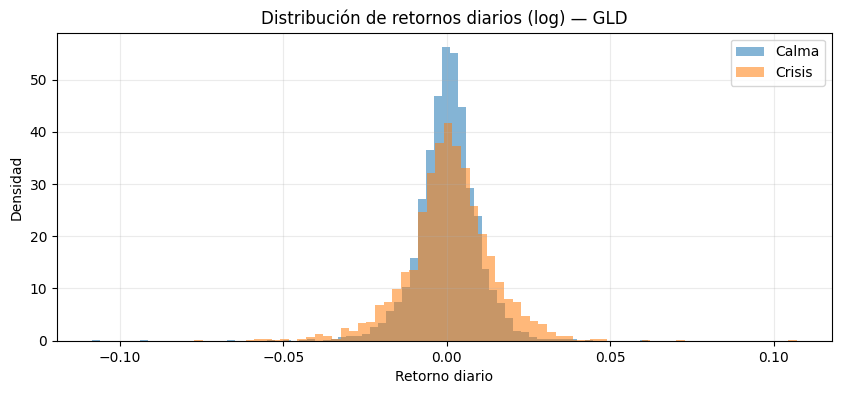

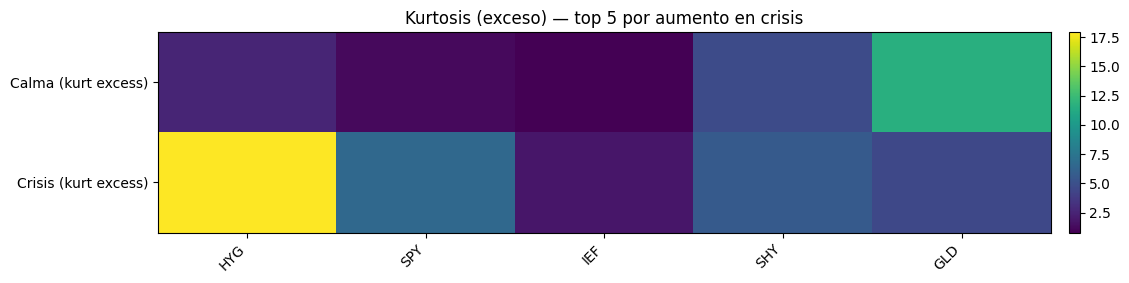

================= RESPUESTAS FASE 2 =================
(HYG) Vol anualizada Calma:  0.0486
(HYG) Vol anualizada Crisis: 0.1659
(HYG) Aumento (%):           241.20%  | Ratio: 3.412
(GLD) Mean anualizada Calma:  0.0472
(GLD) Mean anualizada Crisis: 0.1921  | Δ: 0.1449
(GLD) Vol anualizada Calma:   0.1515
(GLD) Vol anualizada Crisis:  0.2147  | Ratio: 1.417
(GLD vs SPY) Corr Calma: 0.074 | Corr Crisis: 0.041


In [77]:
# -----------------------------
# 1) Estado 0/1: 0=Calma, 1=Crisis
# -----------------------------
wallet_crisis_prediction = (crisis_prediction == int(crisis_state)).astype(int)
wallet_crisis_prediction.name = "state01"

# -----------------------------
# 2) Retornos del universo (log) sin dropna global
# -----------------------------
universe = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL","JNJ",
    "JPM","MSFT","NVDA","PG","XOM",
    "IEF","SHY","HYG","SPY"
]
universe = [t for t in universe if t in px.columns]

R = np.log(px[universe]).diff()  # SIN dropna global
common_idx = R.index.intersection(wallet_crisis_prediction.index)
R = R.loc[common_idx]
wallet_crisis_prediction = wallet_crisis_prediction.loc[common_idx]

# -----------------------------
# 3) Momentos condicionales por estado
# -----------------------------
def moments(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "N": df.count(),
        "mean_d": df.mean(),
        "vol_d": df.std(),
        "skew": df.skew(),
        "kurt_excess": df.kurt()   # exceso de kurtosis (Fisher)
    })
    out["mean_ann"] = out["mean_d"] * 252
    out["vol_ann"]  = out["vol_d"] * np.sqrt(252)
    return out

mom_calm   = moments(R[wallet_crisis_prediction == 0]).add_prefix("calm_")
mom_crisis = moments(R[wallet_crisis_prediction == 1]).add_prefix("crisis_")

tab = pd.concat([mom_calm, mom_crisis], axis=1)

tab["vol_ratio"] = tab["crisis_vol_ann"] / tab["calm_vol_ann"]
tab["vol_increase_%"] = (tab["vol_ratio"] - 1.0) * 100
tab["mean_diff_ann"] = tab["crisis_mean_ann"] - tab["calm_mean_ann"]
tab["kurt_diff"] = tab["crisis_kurt_excess"] - tab["calm_kurt_excess"]
tab["skew_diff"] = tab["crisis_skew"] - tab["calm_skew"]

# Si algún activo tiene pocos datos en un estado, mejor filtrarlo un poco
MIN_N = 400
mask = (tab["calm_N"] >= MIN_N) & (tab["crisis_N"] >= MIN_N)
tab_f = tab[mask].copy()

# -----------------------------
# 4) VISUALES
# -----------------------------
# (A) Top "amplificación" de volatilidad
topN = 12
rank = tab_f.sort_values("vol_increase_%", ascending=False).head(topN)

fig, ax = plt.subplots(figsize=(11, 5))
ax.barh(rank.index[::-1], rank["vol_increase_%"][::-1])
ax.set_title(f"Amplificación de volatilidad en crisis (top {topN})")
ax.set_xlabel("Aumento % de vol anualizada (Crisis vs Calma)")
ax.grid(True, alpha=0.25)
plt.show()

# (B) Scatter: vol crisis vs vol calma (línea 45º)
fig, ax = plt.subplots(figsize=(7, 6))
x = tab_f["calm_vol_ann"].values
y = tab_f["crisis_vol_ann"].values
ax.scatter(x, y)

mx = np.nanmax([x.max(), y.max()])
ax.plot([0, mx], [0, mx], linestyle="--", linewidth=1.2)  # línea 45º

# Etiquetar solo algunos (los más relevantes) para no saturar
labels = tab_f.index.tolist()
for t in labels:
    ax.annotate(t, (tab_f.loc[t, "calm_vol_ann"], tab_f.loc[t, "crisis_vol_ann"]), fontsize=9)

ax.set_title("Vol anualizada: Crisis vs Calma (línea 45º)")
ax.set_xlabel("Vol anualizada (Calma)")
ax.set_ylabel("Vol anualizada (Crisis)")
ax.grid(True, alpha=0.25)
plt.show()

# (C) Mean anualizada: comparación Calma vs Crisis (top 10 por peor media en crisis)
topM = 10
rank_mean = tab_f.sort_values("crisis_mean_ann").head(topM)  # <- aquí definimos rank_mean

fig, ax = plt.subplots(figsize=(11, 5))
idx = np.arange(len(rank_mean))
ax.bar(idx - 0.2, rank_mean["calm_mean_ann"].values, width=0.4, label="Calma")
ax.bar(idx + 0.2, rank_mean["crisis_mean_ann"].values, width=0.4, label="Crisis")
ax.set_xticks(idx)
ax.set_xticklabels(rank_mean.index, rotation=0)
ax.set_title(f"Media anualizada por estado (top {topM} por peor media en crisis)")
ax.set_ylabel("Mean anualizada")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()


# (D) Distribuciones (hist) para HYG y GLD por estado
def plot_hist_asset(ticker, bins=70):
    if ticker not in R.columns:
        print(f"[WARN] {ticker} no está en retornos.")
        return
    r0 = R.loc[wallet_crisis_prediction == 0, ticker].dropna()
    r1 = R.loc[wallet_crisis_prediction == 1, ticker].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(r0.values, bins=bins, density=True, alpha=0.55, label="Calma")
    ax.hist(r1.values, bins=bins, density=True, alpha=0.55, label="Crisis")
    ax.set_title(f"Distribución de retornos diarios (log) — {ticker}")
    ax.set_xlabel("Retorno diario")
    ax.set_ylabel("Densidad")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.show()

plot_hist_asset("HYG")
plot_hist_asset("GLD")

# (E) “Mapa rápido” de colas/asimetría (top por kurtosis diff)
topK = min(15, len(tab_f))
rank_k = tab_f.sort_values("kurt_diff", ascending=False).head(topK)
vals = np.vstack([rank_k["calm_kurt_excess"].values, rank_k["crisis_kurt_excess"].values])

fig, ax = plt.subplots(figsize=(12, 2.6))
im = ax.imshow(vals, aspect="auto")
ax.set_yticks([0,1])
ax.set_yticklabels(["Calma (kurt excess)", "Crisis (kurt excess)"])
ax.set_xticks(np.arange(topK))
ax.set_xticklabels(rank_k.index, rotation=45, ha="right")
ax.set_title(f"Kurtosis (exceso) — top {topK} por aumento en crisis")
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
plt.show()

# -----------------------------
# 5) Respuestas directas a las preguntas (HYG y GLD)
# -----------------------------
print("================= RESPUESTAS FASE 2 =================")

if "HYG" in tab.index:
    hyg = tab.loc["HYG"]
    print(f"(HYG) Vol anualizada Calma:  {hyg['calm_vol_ann']:.4f}")
    print(f"(HYG) Vol anualizada Crisis: {hyg['crisis_vol_ann']:.4f}")
    print(f"(HYG) Aumento (%):           {hyg['vol_increase_%']:.2f}%  | Ratio: {hyg['vol_ratio']:.3f}")
else:
    print("(HYG) No disponible en el dataset.")

if "GLD" in tab.index:
    gld = tab.loc["GLD"]
    print(f"(GLD) Mean anualizada Calma:  {gld['calm_mean_ann']:.4f}")
    print(f"(GLD) Mean anualizada Crisis: {gld['crisis_mean_ann']:.4f}  | Δ: {gld['mean_diff_ann']:.4f}")
    print(f"(GLD) Vol anualizada Calma:   {gld['calm_vol_ann']:.4f}")
    print(f"(GLD) Vol anualizada Crisis:  {gld['crisis_vol_ann']:.4f}  | Ratio: {gld['vol_ratio']:.3f}")

    # Extra: correlación GLD vs SPY condicional
    if "SPY" in R.columns:
        corr_calm = R.loc[wallet_crisis_prediction == 0, "GLD"].corr(R.loc[wallet_crisis_prediction == 0, "SPY"])
        corr_cris = R.loc[wallet_crisis_prediction == 1, "GLD"].corr(R.loc[wallet_crisis_prediction == 1, "SPY"])
        print(f"(GLD vs SPY) Corr Calma: {corr_calm:.3f} | Corr Crisis: {corr_cris:.3f}")
else:
    print("(GLD) No disponible en el dataset.")


## Fase 3 — Cuando la diversificación falla (cópulas)

### 1) Correlación Pearson por régimen
- Se calcula la matriz de correlación de retornos diarios **condicional a cada estado** (HMM).
- Evidencia típica: en *Crisis* aumenta la **correlación media off-diagonal** y la distribución de correlaciones se desplaza hacia valores altos.
- En el subuniverso de **risk assets** (equity + HY) el efecto suele ser más marcado que cuando mezclamos defensivos (bonos/oro).

### 2) t-cópula multivariante (dependencia en colas)
- Se ajusta una **t-cópula** en cada régimen usando pseudo-observaciones (ranks → U(0,1)).
- La t-cópula introduce dependencia en colas mediante los **grados de libertad**:
  - **Alto** ⇒ comportamiento cercano a Gaussiana (colas “finas”) → típico de *Calma*.
  - **Bajo** ⇒ colas gruesas y más probabilidad de extremos conjuntos → típico de *Crisis*.

### 3) Extra: Clayton (bivariada) para cola izquierda
- Se usa **Clayton** como contraste específico de *riesgo*, ya que modela **dependencia de cola inferior**.
- A partir de Kendall  se obtiene theta y la métrica lambda (probabilidad de caídas conjuntas).
- En crisis se observan **pares con lambda significativamente mayor**, apoyando que la diversificación falla precisamente en la cola.

In [78]:
# Subconjuntos para interpretacion
equities = ["AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GME","GOOGL","JNJ","JPM","MSFT","NVDA","PG","XOM"]
def_assets  = ["IEF","SHY","GLD"]
risk_assets = ["HYG"] + equities

wallet = risk_assets + def_assets

print("Activos totales:", len(wallet), "| Risk assets:", len(risk_assets), "| Defensivos:", len(def_assets))

Activos totales: 18 | Risk assets: 15 | Defensivos: 3


In [79]:
#Descarga de todos los tickers
wallet_px = yf.download(
    wallet,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

In [80]:
# Retornos log (sin dropna global)
wallet_returns = np.log(wallet_px).diff()

print("Dias con datos en HMM:", len(crisis_prediction))
print("Dias con datos en la cartera:", len(wallet_returns))

# Cogemos los dias comunes entre HMM y los precios de la cartera
common_idx = wallet_returns.index.intersection(crisis_prediction.index)
wallet_crisis_prediction = crisis_prediction.loc[common_idx]
wallet_returns = wallet_returns.loc[common_idx]

print("Dias en comun:", len(wallet_returns), "| Dias de crisis:", 100 * wallet_crisis_prediction.mean(), "%")

Dias con datos en HMM: 4721
Dias con datos en la cartera: 5059
Dias en comun: 4721 | Dias de crisis: 38.50879051048507 %


In [81]:
def vec_offdiag(df: pd.DataFrame):
    values = df.values
    mask = ~np.eye(values.shape[0], dtype=bool)
    return values[mask]

def offdiag_mean(df: pd.DataFrame) -> float:
    return np.nanmean(vec_offdiag(df))

In [82]:
# -----------------------------
# 1) Correlación Pearson por régimen
# -----------------------------

# Minimo numero de dias que tenemos que tener un ticker en la cartera para considerarlo
TICKER_MIN_SAMPLES = 400

calm_state = 0 if crisis_state else 1

wallet_calm_returns = wallet_returns.loc[wallet_crisis_prediction == calm_state]
wallet_crisis_returns = wallet_returns.loc[wallet_crisis_prediction == crisis_state]

# Nos quedamos los tickers que tengan suficientes datos en ambos regimenes
tickers_to_keep = []
for c in wallet_returns.columns:
    n0 = wallet_calm_returns[c].count()
    n1 = wallet_crisis_returns[c].count()
    if (n0 >= TICKER_MIN_SAMPLES) and (n1 >= TICKER_MIN_SAMPLES):
        tickers_to_keep.append(c)


wallet_calm_returns = wallet_calm_returns[tickers_to_keep]
wallet_crisis_returns = wallet_crisis_returns[tickers_to_keep]

wallet_calm_correlation = wallet_calm_returns.corr(method="pearson")
wallet_crisis_correlation = wallet_crisis_returns.corr(method="pearson")

print(f"Activos con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(tickers_to_keep)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(wallet_calm_correlation))
print("Corr media off-diag (Crisis): ", offdiag_mean(wallet_crisis_correlation))


Activos con N >= 400 en ambos regimenes: 18
Corr media off-diag (Calma):   0.13945614221858216
Corr media off-diag (Crisis):  0.2853095976923845


In [83]:
risk_tickers = [t for t in risk_assets if t in tickers_to_keep]
risk_tickers_calm_returns = wallet_calm_returns[risk_tickers].corr()
risk_tickers_crisis_returns = wallet_calm_returns[risk_tickers].corr()
print(f"Risk Assets con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(risk_tickers)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(risk_tickers_calm_returns))
print("Corr media off-diag (Crisis): ", offdiag_mean(risk_tickers_crisis_returns))
#================================
#Aqui no deberia dar la misma correlacion entre crisis y calma 
#================================

Risk Assets con N >= 400 en ambos regimenes: 15
Corr media off-diag (Calma):   0.20981950576081454
Corr media off-diag (Crisis):  0.20981950576081454


In [84]:
def plot_heatmap_corr(C: pd.DataFrame, title: str, vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(C.values, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(C.shape[1]))
    ax.set_yticks(range(C.shape[0]))
    ax.set_xticklabels(C.columns, rotation=90)
    ax.set_yticklabels(C.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    ax.grid(False)
    plt.show()

### Gráficos

In [85]:
V_MIN = -1
V_MAX = 1
GROUP_RANGE = 0.03

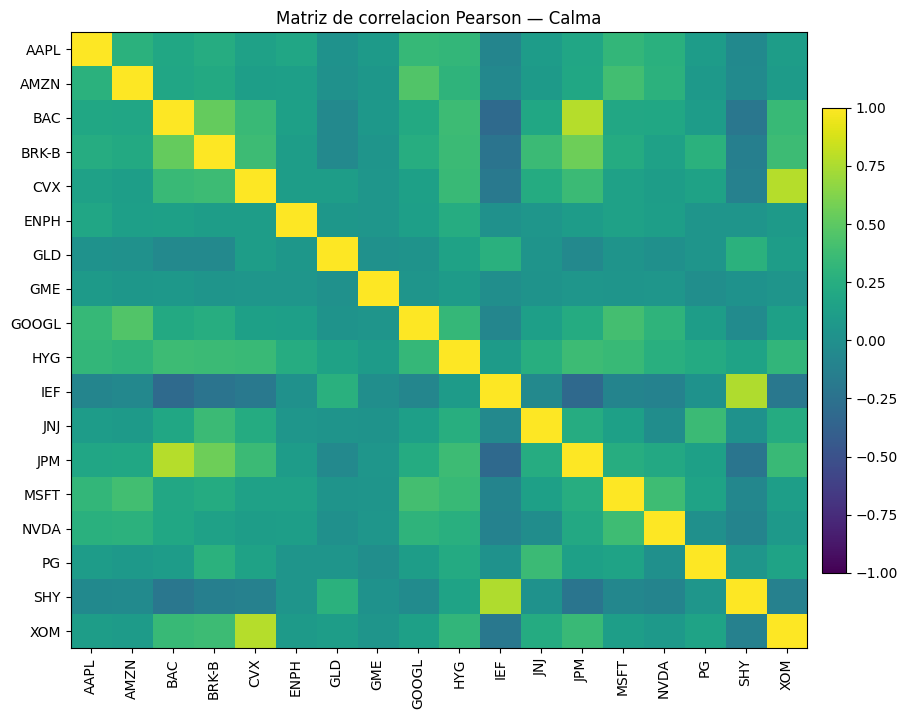

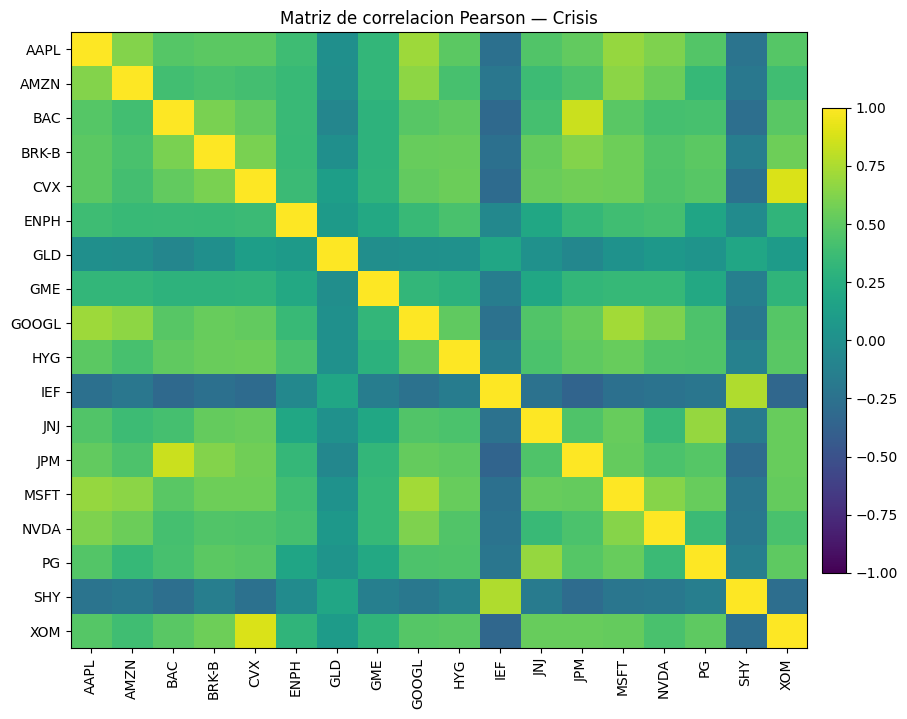

In [86]:
plot_heatmap_corr(wallet_calm_correlation, "Matriz de correlacion Pearson — Calma", vmin=V_MIN, vmax=V_MAX)
plot_heatmap_corr(wallet_crisis_correlation, "Matriz de correlacion Pearson — Crisis", vmin=V_MIN, vmax=V_MAX)

#### Visualización de las correlaciones en grupos de bins

Visualizamos los grupos de las correlaciones de ambas carteras, agrupados por bins

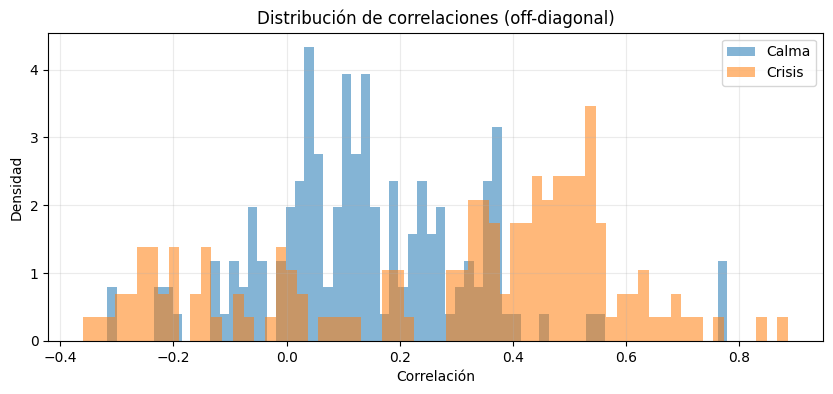

In [87]:
wallet_calm_correlation_values = vec_offdiag(wallet_calm_correlation)
wallet_crisis_correlation_values = vec_offdiag(wallet_crisis_correlation)

bins = int((V_MAX - V_MIN) / GROUP_RANGE)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(wallet_calm_correlation_values, bins=bins, density=True, alpha=0.55, label="Calma")
ax.hist(wallet_crisis_correlation_values, bins=bins, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

### Cópulas

In [88]:
def pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """Pseudo-observaciones U(0,1) via ranks: u = rank/(n+1)."""
    X = df.values
    n, k = X.shape
    U = np.empty_like(X, dtype=float)
    for j in range(k):
        col = X[:, j]
        # rankdata maneja empates
        r = st.rankdata(col, method="average")
        U[:, j] = r / (n + 1.0)
    return U

def nearest_psd(A: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Proyecta a PSD por clipping de eigenvalores."""
    A = 0.5 * (A + A.T)
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, eps)
    B = (V * w) @ V.T
    # normalizar a correlación (diag = 1)
    d = np.sqrt(np.diag(B))
    B = B / np.outer(d, d)
    return 0.5 * (B + B.T)

def t_tail_dependence(rho: float, nu: float) -> float:
    """
    Coeficiente de dependencia en cola (simétrica) para t-copula:
    λ = 2 * t_{nu+1}(-sqrt((nu+1)*(1-rho)/(1+rho)))
    """
    if rho >= 0.999999:
        return 1.0
    if rho <= -0.999999:
        return 0.0
    a = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return 2.0 * st.t.cdf(a, df=nu + 1.0)


def fit_t_copula_ifm(df: pd.DataFrame, nu_grid, shrink=0.02):

    X = df.dropna(axis=0, how="any")

    U = pseudo_obs(X)
    k = U.shape[1]
    ll_list = []

    for nu in nu_grid:
        # Transformación t
        Z = st.t.ppf(U, df=nu)
        # Correlación en el espacio latente
        Rho = np.corrcoef(Z, rowvar=False)
        # Shrinkage leve para estabilidad
        Rho = (1 - shrink) * Rho + shrink * np.eye(k)
        Rho = nearest_psd(Rho)

        # log c(u) = log f_tk(Z;nu,Rho) - sum log f_t1(Z_i;nu)
        mvt = st.multivariate_t(loc=np.zeros(k), shape=Rho, df=nu)
        ll_m = mvt.logpdf(Z).sum()
        ll_u = st.t.logpdf(Z, df=nu).sum()
        ll = ll_m - ll_u
        ll_list.append((nu, ll, len(X), k))

    ll_df = pd.DataFrame(ll_list, columns=["nu", "loglik", "N", "K"]).sort_values("loglik", ascending=False)
    nu_hat = int(ll_df.iloc[0]["nu"])

    # Re-estimar Rho con nu_hat
    Z = st.t.ppf(U, df=nu_hat)
    Rho = np.corrcoef(Z, rowvar=False)
    Rho = (1 - shrink) * Rho + shrink * np.eye(k)
    Rho = nearest_psd(Rho)

    return nu_hat, Rho, ll_df, X.columns

In [89]:
print("--- Ajuste t-copula (multivariante) ---")
print("Activos usados para copula:", tickers_to_keep)

wallet_calm_returns = wallet_calm_returns.dropna(how="any")
wallet_crisis_returns = wallet_crisis_returns.dropna(how="any")

nu_grid = [5,6,7,8,9,10,12,15,20,30,50,80, 100]
calm_nu, nu_calm_corr, calm_ll, calm_columns = fit_t_copula_ifm(wallet_calm_returns, nu_grid=nu_grid, shrink=0.02)
crisis_nu, nu_crisis_corr, crisis_ll, crisis_columns = fit_t_copula_ifm(wallet_crisis_returns, nu_grid=nu_grid, shrink=0.02)

# Un valor alto indica colas mas grandes (mas separados). Un valor pequenho indica que los activos estan mas correlacionados
print(f"t-copula Calma:  nu_hat = {calm_nu}")
print(f"t-copula Crisis: nu_hat = {crisis_nu}")

--- Ajuste t-copula (multivariante) ---
Activos usados para copula: ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 'HYG', 'IEF', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'SHY', 'XOM']
t-copula Calma:  nu_hat = 15
t-copula Crisis: nu_hat = 10


In [90]:
# Plot ll vs nu
def plot_ll(ll_df, title):
    tmp = ll_df.sort_values("nu")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(tmp["nu"], tmp["loglik"], marker="o")
    ax.set_title(title)
    ax.set_xlabel("nu (df)")
    ax.set_ylabel("log-likelihood (copula)")
    ax.grid(True, alpha=0.25)
    plt.show()

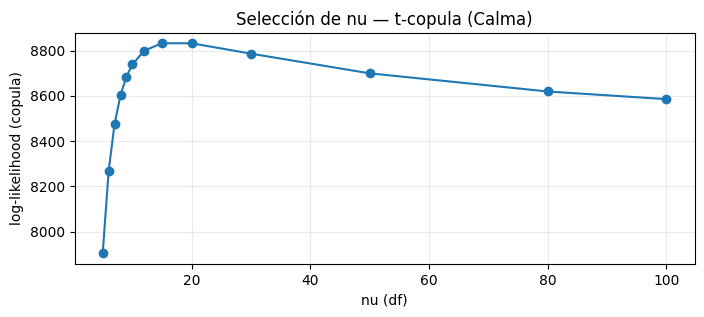

t-copula — Calma (mejores nu por log-likelihood)


,nu,loglik,N,K
7,15,8832.756646,2478,18
8,20,8832.474068,2478,18
6,12,8799.587856,2478,18
9,30,8786.570141,2478,18
5,10,8739.020154,2478,18
10,50,8699.574621,2478,18
4,9,8685.063398,2478,18
11,80,8619.424202,2478,18
3,8,8603.336170,2478,18
12,100,8585.528253,2478,18


In [91]:
plot_ll(calm_ll, "Selección de nu — t-copula (Calma)")
print("t-copula — Calma (mejores nu por log-likelihood)")
calm_ll.head(10)

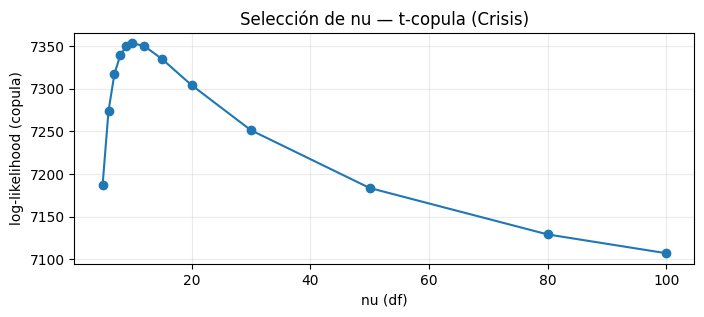

t-copula — Crisis (mejores nu por log-likelihood)


,nu,loglik,N,K
5,10,7353.353801,1008,18
6,12,7350.170324,1008,18
4,9,7349.765329,1008,18
3,8,7339.504323,1008,18
7,15,7334.930473,1008,18
2,7,7317.576364,1008,18
8,20,7304.205073,1008,18
1,6,7274.023102,1008,18
9,30,7251.341011,1008,18
0,5,7186.873699,1008,18


In [92]:
plot_ll(crisis_ll, "Selección de nu — t-copula (Crisis)")
print("t-copula — Crisis (mejores nu por log-likelihood)")
crisis_ll.head(10)

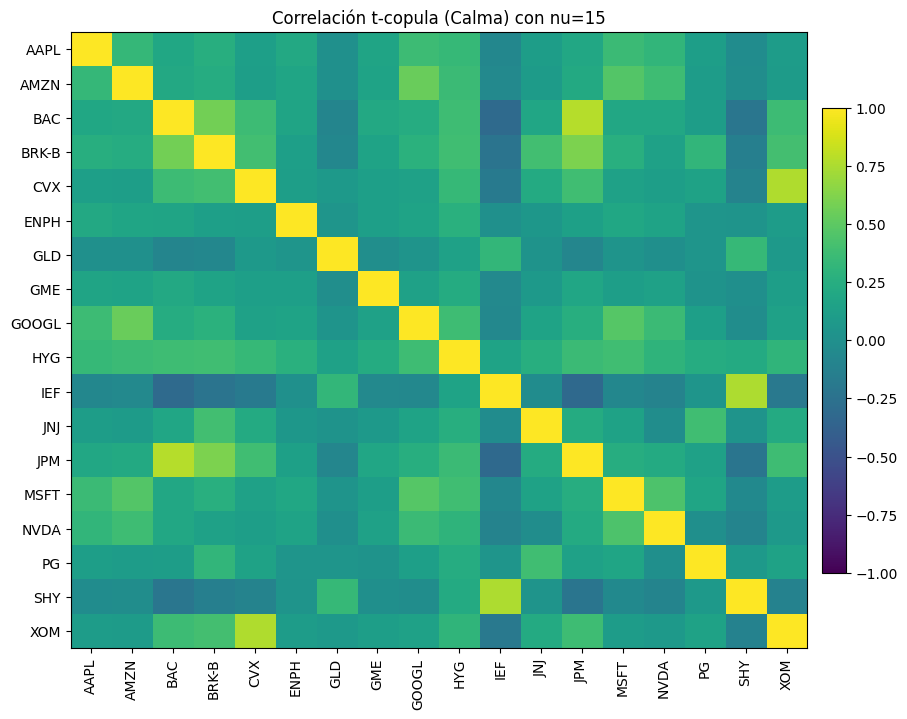

In [93]:
nu_calm_corr_df = pd.DataFrame(nu_calm_corr, index=calm_columns, columns=calm_columns)
plot_heatmap_corr(nu_calm_corr_df, f"Correlación t-copula (Calma) con nu={calm_nu}", vmin=-1, vmax=1)

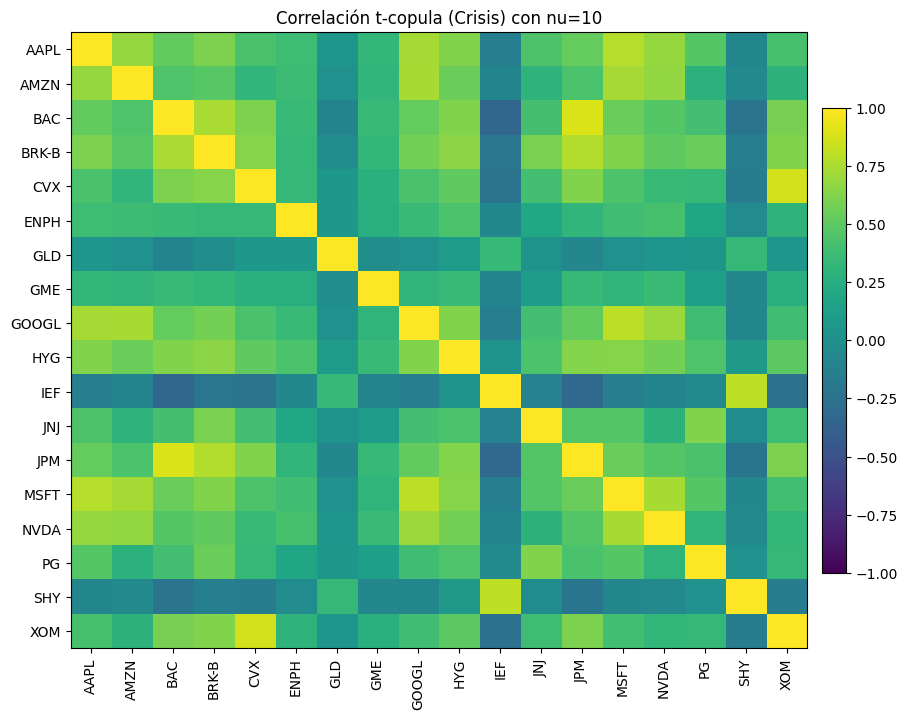

In [94]:
nu_crisis_corr_df = pd.DataFrame(nu_crisis_corr, index=crisis_columns, columns=crisis_columns)
plot_heatmap_corr(nu_crisis_corr_df, f"Correlación t-copula (Crisis) con nu={crisis_nu}", vmin=-1, vmax=1)

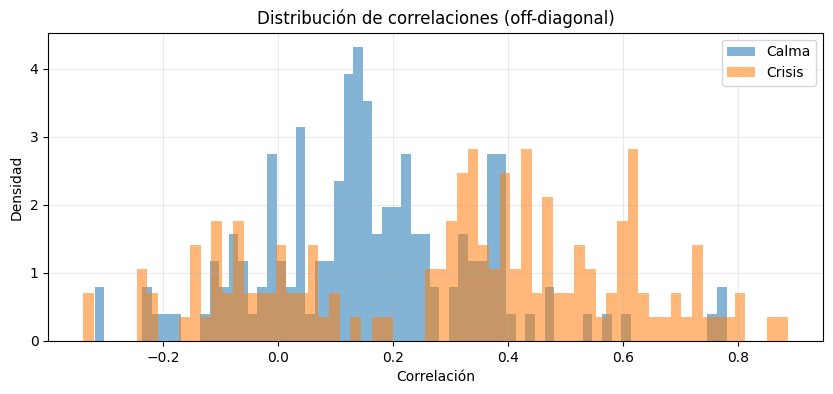

In [95]:
copula_calm_correlation_values = vec_offdiag(nu_calm_corr_df)
copula_crisis_correlation_values = vec_offdiag(nu_crisis_corr_df)

bins = int((V_MAX - V_MIN) / GROUP_RANGE)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(copula_calm_correlation_values, bins=bins, density=True, alpha=0.55, label="Calma")
ax.hist(copula_crisis_correlation_values, bins=bins, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

In [96]:
def pair_table_taildep(Rho, cols, nu, top=12):
    cols = list(cols)
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            rho = float(Rho[i, j])
            lam = t_tail_dependence(rho, nu)
            out.append((cols[i], cols[j], rho, lam))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","rho_latent","lambda_tail"])
    df = df.sort_values("lambda_tail", ascending=False)
    return df.head(top), df


top1, all1 = pair_table_taildep(nu_crisis_corr, crisis_columns, crisis_nu, top=12)

In [97]:
top0, all0 = pair_table_taildep(nu_calm_corr, calm_columns, calm_nu, top=12)
print("t-copula — Top tail dependence (Calma)")
top0.head(12)

t-copula — Top tail dependence (Calma)


,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.780409,0.179204
74,CVX,XOM,0.765541,0.164284
130,IEF,SHY,0.756162,0.155546
56,BRK-B,JPM,0.608871,0.066122
33,BAC,BRK-B,0.573362,0.053659
23,AMZN,GOOGL,0.540151,0.044052
112,GOOGL,MSFT,0.473235,0.029392
28,AMZN,MSFT,0.466954,0.028281
143,MSFT,NVDA,0.441408,0.024151
61,BRK-B,XOM,0.400273,0.018655


In [98]:
top1, all1 = pair_table_taildep(nu_crisis_corr, crisis_columns, crisis_nu, top=12)
print("t-copula — Top tail dependence (Crisis)")
top1.head(12)

t-copula — Top tail dependence (Crisis)


,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.887246,0.434739
74,CVX,XOM,0.861212,0.384515
130,IEF,SHY,0.808374,0.303406
112,GOOGL,MSFT,0.804454,0.298252
12,AAPL,MSFT,0.779112,0.267252
56,BRK-B,JPM,0.771894,0.259098
33,BAC,BRK-B,0.747833,0.233825
23,AMZN,GOOGL,0.735245,0.221673
143,MSFT,NVDA,0.734724,0.221186
28,AMZN,MSFT,0.733946,0.220459


In [99]:
print("Resumen tail dependence (t-copula):")
print("Media λ (Calma): ", all0["lambda_tail"].mean())
print("Media λ (Crisis):", all1["lambda_tail"].mean())

Resumen tail dependence (t-copula):
Media λ (Calma):  0.009618172704535443
Media λ (Crisis): 0.06797022306258174


Fase 4

[REAL] Periodo: 2007-05-09 -> 2026-02-11
[REAL] Nº días (retornos): 4721 | Nº activos: 18
[REAL] Wealth final (base 1): 24.344


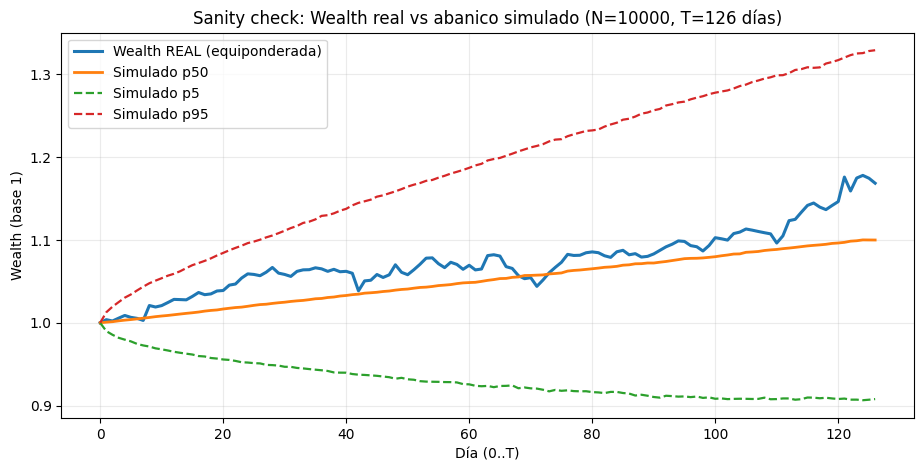

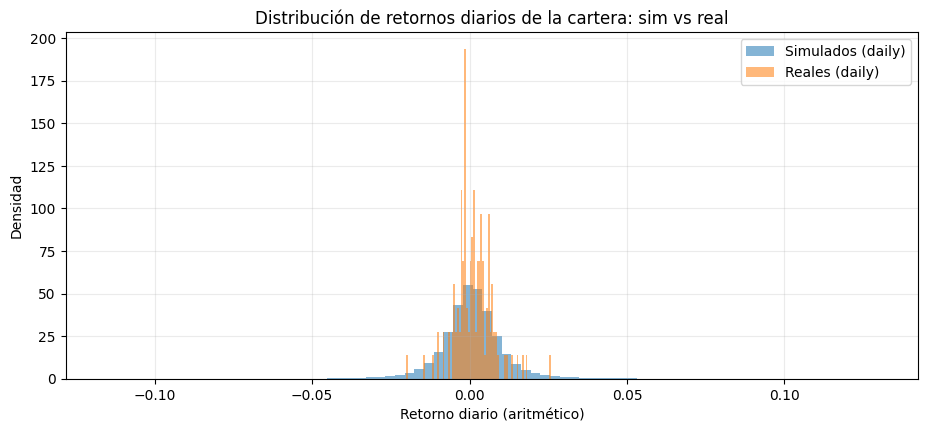


Percentiles retornos diarios cartera (aritméticos)
q    real       sim
 1%  -0.01370  -0.02779
 5%  -0.00777  -0.01473
50%   0.00096   0.00068
95%   0.01082   0.01649
99%   0.01766   0.03153


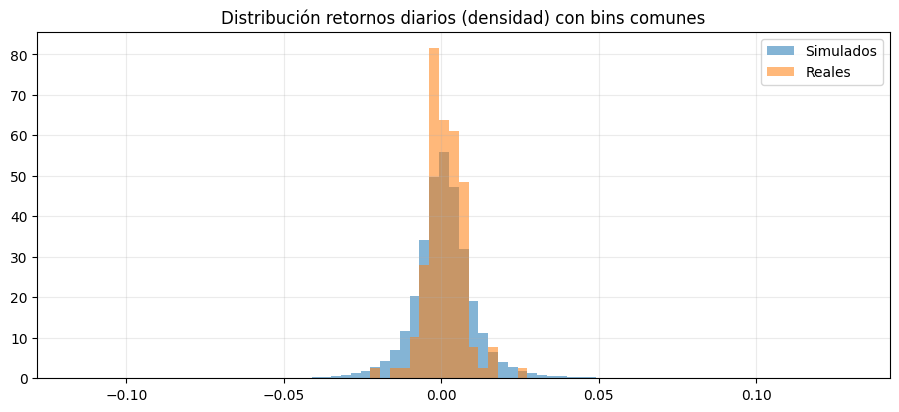

In [108]:
# ============================================================
# SANITY CHECK (cartera equiponderada + abanico simulado)
#   - Wealth real (histórico)
#   - 10.000 simulaciones (H ~ 6 meses) -> wealth p5/p50/p95
#   - Distribución retornos diarios: real vs sim
# ============================================================


# Orden y universo de activos (IMPORTANTE: que coincida con el orden de la cópula)
if "calm_columns" in globals():
    assets = list(calm_columns)
elif "tickers_to_keep" in globals():
    assets = list(tickers_to_keep)
else:
    assets = list(wallet_returns.columns)

assets = [a for a in assets if a in wallet_returns.columns]
k = len(assets)
if k < 2:
    raise ValueError("Necesito al menos 2 activos en `assets` para el sanity check.")

# Asegurar que las matrices de correlación de la cópula tienen la misma dimensión que assets
if nu_calm_corr.shape != (k, k) or nu_crisis_corr.shape != (k, k):
    raise ValueError(
        f"Dimensiones no cuadran: k={k}, "
        f"nu_calm_corr={nu_calm_corr.shape}, nu_crisis_corr={nu_crisis_corr.shape}. "
        "Revisa que `assets` esté en el mismo orden que la calibración de la cópula."
    )

# Estados
crisis_state = int(crisis_state)
calm_state = 1 - crisis_state

# Horizonte ~ 6 meses (trading days)
H_DEFAULT = 126
N_PATHS = 10_000

# -----------------------------
# 1) Cartera equiponderada real (wealth index histórico)
# -----------------------------
# Log-returns -> arithmetic returns por activo
logR = wallet_returns[assets]
arithR = np.expm1(logR)  # r = exp(logr)-1

# Equiponderada con renormalización implícita si hay NaNs (mean ignora NaN)
port_ret_full = arithR.mean(axis=1).dropna()  # retorno diario (aritmético) de la cartera

wealth_real_full = (1.0 + port_ret_full).cumprod()

print(f"[REAL] Periodo: {port_ret_full.index.min().date()} -> {port_ret_full.index.max().date()}")
print(f"[REAL] Nº días (retornos): {len(port_ret_full)} | Nº activos: {k}")
print(f"[REAL] Wealth final (base 1): {wealth_real_full.iloc[-1]:.3f}")

# Ventana de comparación (últimos ~6 meses)
T = min(H_DEFAULT, len(port_ret_full))
port_ret_real = port_ret_full.iloc[-T:]
wealth_real = np.empty(T + 1)
wealth_real[0] = 1.0
wealth_real[1:] = np.cumprod(1.0 + port_ret_real.values)

# Estado inicial para la simulación: estado al inicio de la ventana real (más “justo” para comparar)
state_aligned = wallet_crisis_prediction.reindex(port_ret_real.index, method="ffill")
s0 = int(state_aligned.iloc[0])

# -----------------------------
# 2) Preparar marginales empíricas por estado (para inverse-CDF rápida)
# -----------------------------
# Si ya tienes wallet_calm_returns / wallet_crisis_returns (log), los usamos
if "wallet_calm_returns" in globals() and "wallet_crisis_returns" in globals():
    calm_data = wallet_calm_returns[assets].dropna(how="any")
    crisis_data = wallet_crisis_returns[assets].dropna(how="any")
else:
    # fallback: construirlos desde wallet_returns + wallet_crisis_prediction
    calm_data = wallet_returns.loc[wallet_crisis_prediction == calm_state, assets].dropna(how="any")
    crisis_data = wallet_returns.loc[wallet_crisis_prediction == crisis_state, assets].dropna(how="any")

if len(calm_data) < 200 or len(crisis_data) < 200:
    print(f"[WARN] Pocos datos por estado: calma={len(calm_data)}, crisis={len(crisis_data)}. "
          "El inverse-CDF empírico puede ser ruidoso.")

sorted_calm = np.sort(calm_data.values, axis=0)    # (n0, k)
sorted_cris = np.sort(crisis_data.values, axis=0)  # (n1, k)

def inv_ecdf_from_sorted(U: np.ndarray, sorted_vals: np.ndarray) -> np.ndarray:
    """
    Inversa empírica rápida usando array ordenado por columna.
    U: (m,k) en (0,1)
    sorted_vals: (n,k) retornos log ordenados por columna
    """
    n = sorted_vals.shape[0]
    # índices fraccionales
    x = U * (n - 1)
    i0 = np.floor(x).astype(int)
    i1 = np.minimum(i0 + 1, n - 1)
    w = x - i0

    v0 = np.take_along_axis(sorted_vals, i0, axis=0)
    v1 = np.take_along_axis(sorted_vals, i1, axis=0)
    return v0 + (v1 - v0) * w

# -----------------------------
# 3) Simulación Monte Carlo (HMM + t-cópula por estado + marginales empíricas)
# -----------------------------
P = np.asarray(hmm.transmat_)
n_states = P.shape[0]
if n_states != 2:
    print(f"[INFO] HMM con {n_states} estados (este sanity check está pensado para 2, pero funciona igual).")

rng = np.random.default_rng(globals().get("SEED", 123))

# Contenedores
S = np.empty((N_PATHS, T), dtype=np.int8)
port_ret_sim = np.empty((N_PATHS, T), dtype=np.float64)
s = np.full(N_PATHS, s0, dtype=np.int8)

eps = 1e-12

for t in range(T):
    S[:, t] = s

    # Simular retornos condicional al estado
    for st_ in np.unique(s):
        idx = np.where(s == st_)[0]
        m = len(idx)
        if m == 0:
            continue

        # Parámetros por estado
        if int(st_) == crisis_state:
            nu = int(crisis_nu)
            Rho = np.asarray(nu_crisis_corr)
            sorted_vals = sorted_cris
        else:
            nu = int(calm_nu)
            Rho = np.asarray(nu_calm_corr)
            sorted_vals = sorted_calm

        # 1) t-cópula: muestrear Z ~ t_k(0, Rho, nu) y pasar a U con CDF univariante t
        Z = st.multivariate_t(loc=np.zeros(k), shape=Rho, df=nu).rvs(size=m, random_state=rng)
        Z = np.atleast_2d(Z)
        U = st.t.cdf(Z, df=nu)
        U = np.clip(U, eps, 1 - eps)

        # 2) Marginales empíricas (log-returns)
        logR_sim = inv_ecdf_from_sorted(U, sorted_vals)

        # 3) Cartera equiponderada (aritmética) y guardar
        port_ret_sim[idx, t] = np.expm1(logR_sim).mean(axis=1)

    # Transición Markov -> siguiente estado
    # new_s = argmin{j: u <= sum_{r<=j} P[s, r]}
    u = rng.random(N_PATHS)
    cumP = np.cumsum(P[s], axis=1)  # (N, n_states)
    s = (u[:, None] > cumP).sum(axis=1).astype(np.int8)

# Wealth paths
wealth_sim = np.empty((N_PATHS, T + 1), dtype=np.float64)
wealth_sim[:, 0] = 1.0
for t in range(T):
    wealth_sim[:, t + 1] = wealth_sim[:, t] * (1.0 + port_ret_sim[:, t])

p5  = np.percentile(wealth_sim,  5, axis=0)
p50 = np.percentile(wealth_sim, 50, axis=0)
p95 = np.percentile(wealth_sim, 95, axis=0)

# -----------------------------
# 4) Comparación: trayectoria real vs abanico simulado
# -----------------------------
x = np.arange(T + 1)

plt.figure(figsize=(11, 5))
plt.plot(x, wealth_real, linewidth=2.2, label="Wealth REAL (equiponderada)")
plt.plot(x, p50, linewidth=2.0, label="Simulado p50")
plt.plot(x, p5,  linestyle="--", linewidth=1.6, label="Simulado p5")
plt.plot(x, p95, linestyle="--", linewidth=1.6, label="Simulado p95")
plt.title(f"Sanity check: Wealth real vs abanico simulado (N={N_PATHS}, T={T} días)")
plt.xlabel("Día (0..T)")
plt.ylabel("Wealth (base 1)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

# -----------------------------
# 5) Distribución retornos diarios: real vs sim (histograma + percentiles)
# -----------------------------
sim_daily = port_ret_sim.ravel()
real_daily = port_ret_real.values

plt.figure(figsize=(11, 4.5))
plt.hist(sim_daily, bins=80, density=True, alpha=0.55, label="Simulados (daily)")
plt.hist(real_daily, bins=80, density=True, alpha=0.55, label="Reales (daily)")
plt.title("Distribución de retornos diarios de la cartera: sim vs real")
plt.xlabel("Retorno diario (aritmético)")
plt.ylabel("Densidad")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

# Percentiles como check rápido (más robusto que solo el hist)
qs = [1, 5, 50, 95, 99]
print("\nPercentiles retornos diarios cartera (aritméticos)")
print("q    real       sim")
for q in qs:
    print(f"{q:>2}%  {np.percentile(real_daily, q): .5f}  {np.percentile(sim_daily, q): .5f}")

# Distribucion de retornos entre real y simulado 
all_data = np.r_[sim_daily, real_daily]
bins = np.linspace(all_data.min(), all_data.max(), 80)

plt.figure(figsize=(11,4.5))
plt.hist(sim_daily, bins=bins, density=True, alpha=0.55, label="Simulados")
plt.hist(real_daily, bins=bins, density=True, alpha=0.55, label="Reales")
plt.title("Distribución retornos diarios (densidad) con bins comunes")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()



[Ventana] T=126 días | N=10000 trayectorias
REAL % días por estado: {0: 1.0, 1: 0.0}
REAL duración media spells: {0: 126.0, 1: nan}
REAL switches: 0


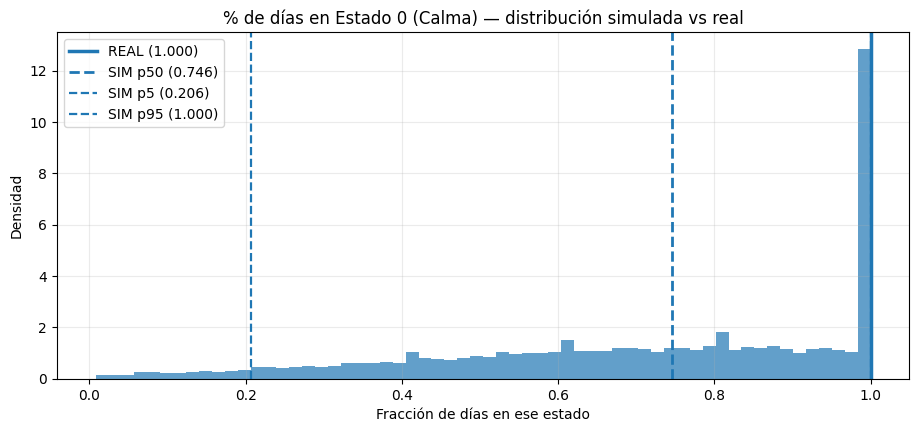

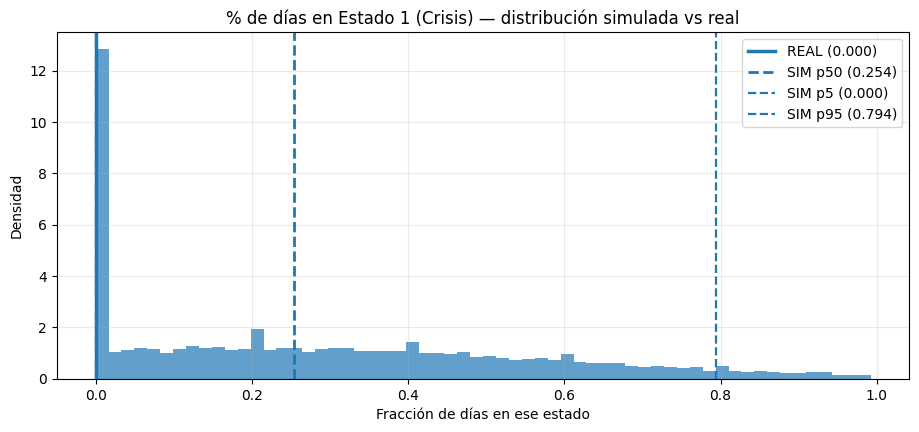

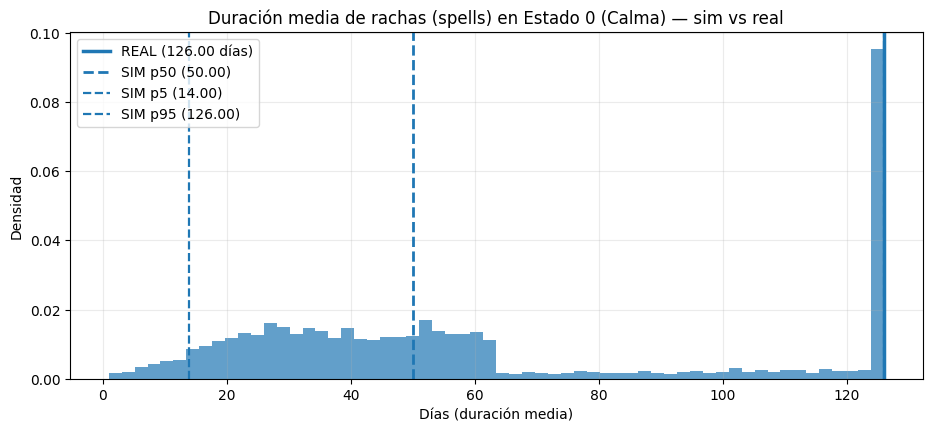

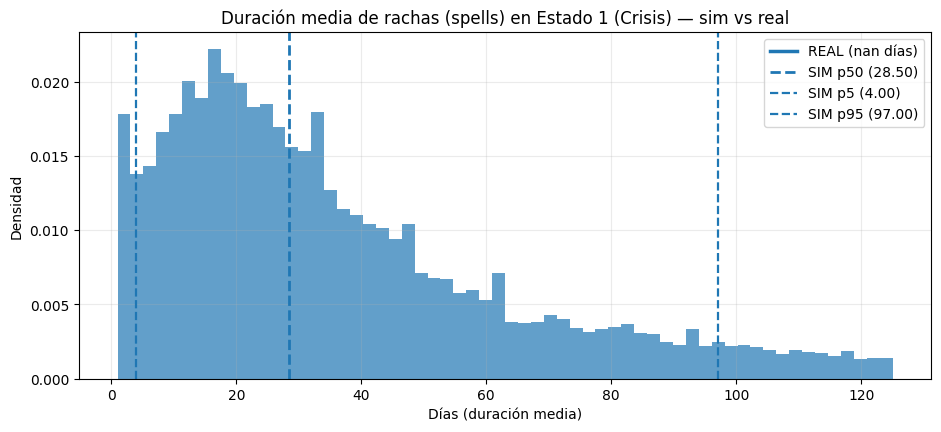

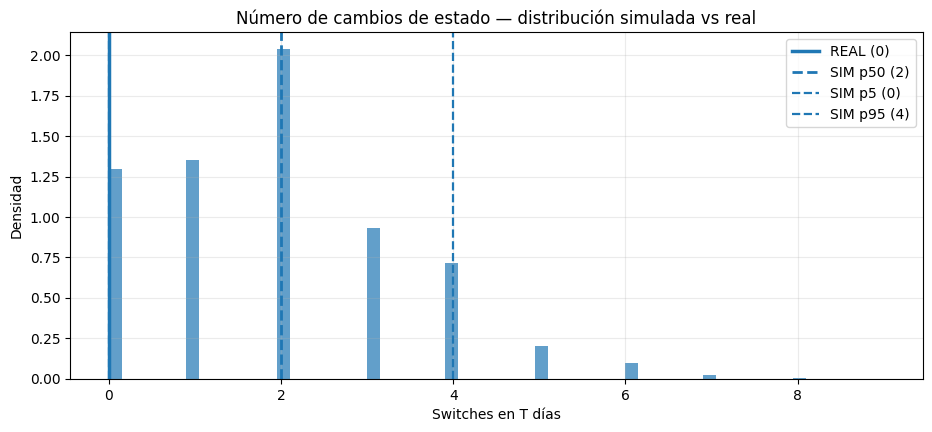

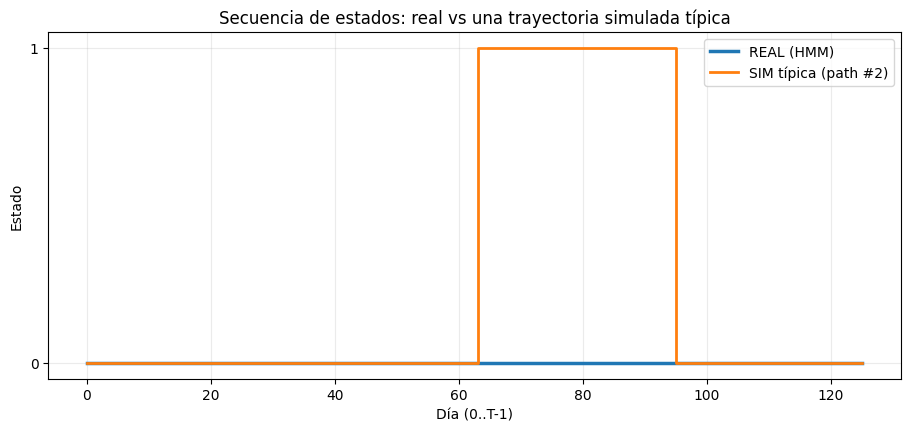

In [ ]:
# ============================================================
# Reproducción de regímenes (REAL vs SIM)
#   - % días por estado (dist sim + línea real)
#   - duración media de spells por estado (dist sim + línea real)
#   - nº switches (dist sim + línea real)
#   - ejemplo de trayectoria de estados (real vs sim típica)
# ============================================================

S = np.asarray(S)
N_PATHS, T = S.shape

# Estados reales alineados a la misma ventana
if "state_aligned" in globals():
    s_real = pd.Series(state_aligned.values, index=port_ret_real.index).astype(int).values
else:
    state_aligned = wallet_crisis_prediction.reindex(port_ret_real.index, method="ffill")
    s_real = state_aligned.astype(int).values

if len(s_real) != T:
    raise ValueError(f"Estados reales ({len(s_real)}) != T simulado ({T}). Revisa alineación.")

# Conjunto de estados
states_set = np.unique(np.r_[np.unique(s_real), np.unique(S)])
states_set = np.array(sorted(states_set))

# Etiquetas (si tienes crisis_state)
def state_label(st):
    if "crisis_state" in globals() and len(states_set) == 2:
        st = int(st)
        if st == int(crisis_state):
            return f"Estado {st} (Crisis)"
        else:
            return f"Estado {st} (Calma)"
    return f"Estado {int(st)}"

# -----------------------------
# 1) Helpers: spells y métricas
# -----------------------------
def _spells_and_lengths(s_1d: np.ndarray):
    s = np.asarray(s_1d).astype(int)
    if s.size <= 1:
        return s.copy(), np.array([s.size]), 0
    cuts = np.flatnonzero(s[1:] != s[:-1]) + 1
    idx = np.r_[0, cuts, s.size]
    st_spells = s[idx[:-1]]
    len_spells = np.diff(idx)
    n_switch = int(cuts.size)
    return st_spells, len_spells, n_switch

def regime_stats_1d(s_1d: np.ndarray, states_all: np.ndarray):
    s = np.asarray(s_1d).astype(int)
    pct = {st: float(np.mean(s == st)) for st in states_all}
    st_spells, len_spells, n_switch = _spells_and_lengths(s)
    mean_dur = {}
    for st in states_all:
        Ls = len_spells[st_spells == st]
        mean_dur[st] = float(np.mean(Ls)) if Ls.size > 0 else np.nan
    return pct, mean_dur, n_switch

def qsum(x):
    x = np.asarray(x)
    return float(np.nanpercentile(x, 5)), float(np.nanpercentile(x, 50)), float(np.nanpercentile(x, 95))

# REAL
pct_real, dur_real, sw_real = regime_stats_1d(s_real, states_set)

# SIM (vector + loop barato)
pct_sim_paths = {st: (S == st).mean(axis=1) for st in states_set}
dur_sim_paths = {st: np.full(N_PATHS, np.nan) for st in states_set}
sw_sim_paths = np.empty(N_PATHS, dtype=float)

for i in range(N_PATHS):
    st_spells, len_spells, n_sw = _spells_and_lengths(S[i])
    sw_sim_paths[i] = n_sw
    for st in states_set:
        Ls = len_spells[st_spells == st]
        dur_sim_paths[st][i] = np.mean(Ls) if Ls.size > 0 else np.nan

print(f"[Ventana] T={T} días | N={N_PATHS} trayectorias")
print("REAL % días por estado:", {int(k): round(v, 4) for k,v in pct_real.items()})
print("REAL duración media spells:", {int(k): round(v, 2) for k,v in dur_real.items()})
print("REAL switches:", sw_real)

# -----------------------------
# 2) GRÁFICO A: % días en cada estado (dist sim + línea real)
# -----------------------------
for st in states_set:
    x = pct_sim_paths[st]
    p5, p50, p95 = qsum(x)

    plt.figure(figsize=(11, 4.5))
    plt.hist(x, bins=60, density=True, alpha=0.7)
    plt.axvline(pct_real[st], linewidth=2.5, label=f"REAL ({pct_real[st]:.3f})")
    plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 ({p50:.3f})")
    plt.axvline(p5, linestyle="--", linewidth=1.6, label=f"SIM p5 ({p5:.3f})")
    plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 ({p95:.3f})")
    plt.title(f"% de días en {state_label(st)} — distribución simulada vs real")
    plt.xlabel("Fracción de días en ese estado")
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

# -----------------------------
# 3) GRÁFICO B: Duración media de spells por estado
# -----------------------------
for st in states_set:
    x = dur_sim_paths[st]
    x = x[np.isfinite(x)]
    p5, p50, p95 = qsum(x)

    plt.figure(figsize=(11, 4.5))
    plt.hist(x, bins=60, density=True, alpha=0.7)
    plt.axvline(dur_real[st], linewidth=2.5, label=f"REAL ({dur_real[st]:.2f} días)")
    plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 ({p50:.2f})")
    plt.axvline(p5, linestyle="--", linewidth=1.6, label=f"SIM p5 ({p5:.2f})")
    plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 ({p95:.2f})")
    plt.title(f"Duración media de rachas (spells) en {state_label(st)} — sim vs real")
    plt.xlabel("Días (duración media)")
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

# -----------------------------
# 4) GRÁFICO C: Nº cambios de estado (switches)
# -----------------------------
p5, p50, p95 = qsum(sw_sim_paths)

plt.figure(figsize=(11, 4.5))
plt.hist(sw_sim_paths, bins=60, density=True, alpha=0.7)
plt.axvline(sw_real, linewidth=2.5, label=f"REAL ({sw_real})")
plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 ({p50:.0f})")
plt.axvline(p5, linestyle="--", linewidth=1.6, label=f"SIM p5 ({p5:.0f})")
plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 ({p95:.0f})")
plt.title("Número de cambios de estado — distribución simulada vs real")
plt.xlabel("Switches en T días")
plt.ylabel("Densidad")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

# -----------------------------
# 5) GRÁFICO D: Trayectoria de estados (real vs simulada “típica”)
#   - elegimos la trayectoria cuyo % de crisis esté más cerca de la mediana (si hay crisis_state)
# -----------------------------
if "crisis_state" in globals() and len(states_set) == 2:
    crisis = int(crisis_state)
    share = (S == crisis).mean(axis=1)
    target = np.percentile(share, 50)
    i_star = int(np.argmin(np.abs(share - target)))
else:
    # fallback: escogemos la de switches más cercana a la mediana
    target = np.percentile(sw_sim_paths, 50)
    i_star = int(np.argmin(np.abs(sw_sim_paths - target)))

plt.figure(figsize=(11, 4.5))
plt.step(np.arange(T), s_real, where="post", linewidth=2.5, label="REAL (HMM)")
plt.step(np.arange(T), S[i_star], where="post", linewidth=2.0, label=f"SIM típica (path #{i_star})")
plt.title("Secuencia de estados: real vs una trayectoria simulada típica")
plt.xlabel("Día (0..T-1)")
plt.ylabel("Estado")
plt.yticks(states_set)
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


,REAL,SIM mean,SIM p5,SIM p50,SIM p95
Vol diaria,0.006072,0.010157,0.006770,0.009947,0.014298
Vol anualizada,0.096386,0.161242,0.107464,0.157897,0.226976
Max Drawdown,-0.035277,-0.092778,-0.190175,-0.081578,-0.035832
VaR 99% (loss),0.013698,0.024096,0.013022,0.023111,0.038607
ES 99% (loss),0.017178,0.029389,0.015053,0.027985,0.049166


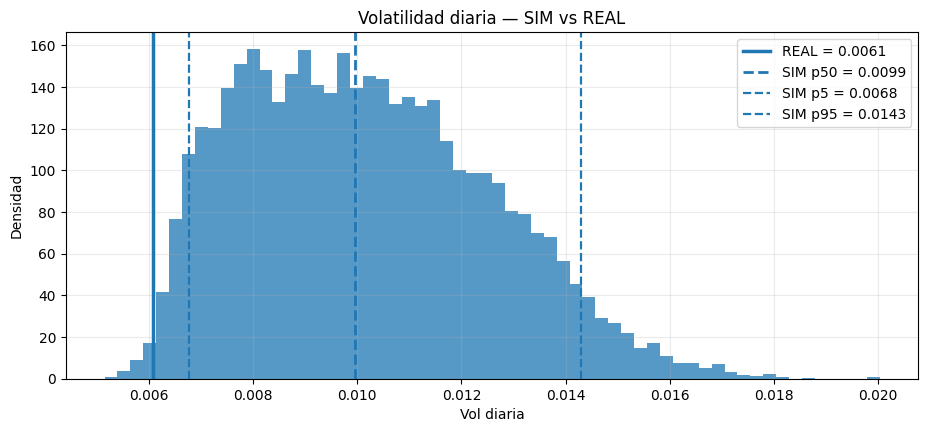

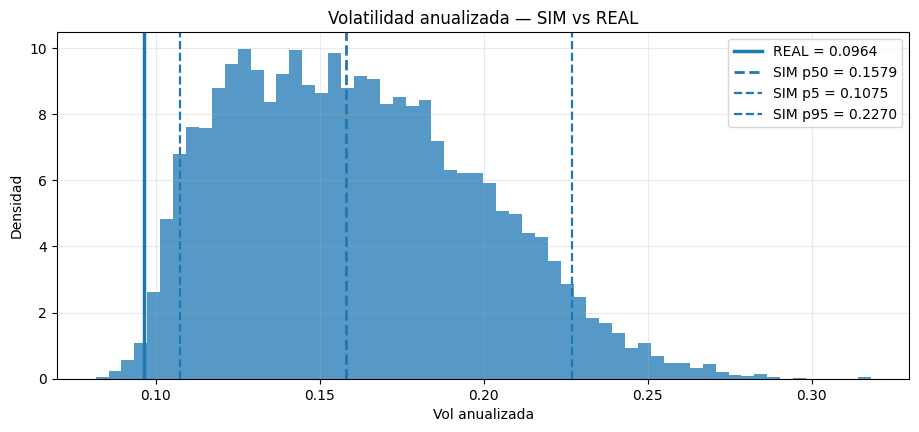

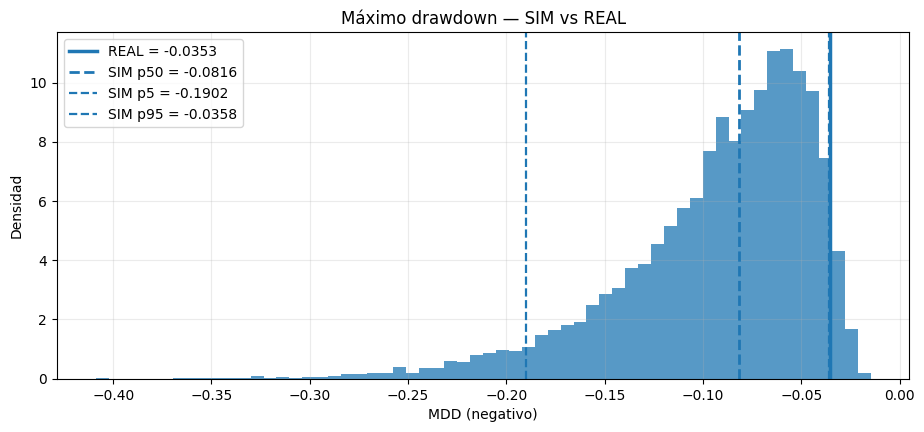

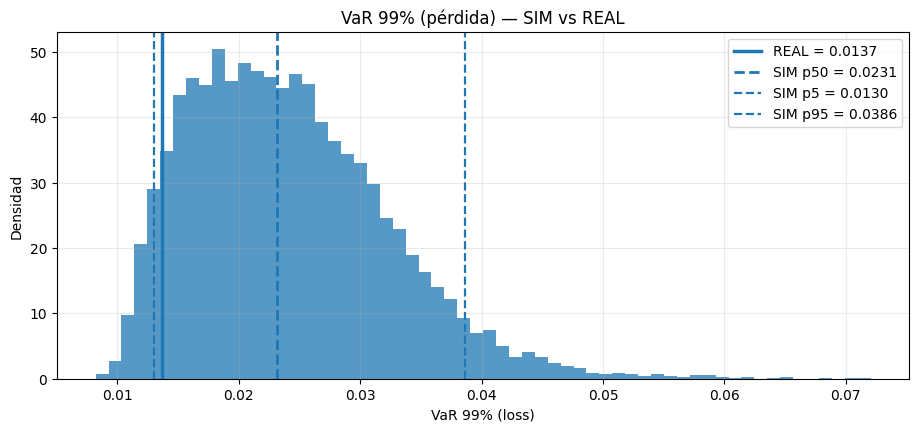

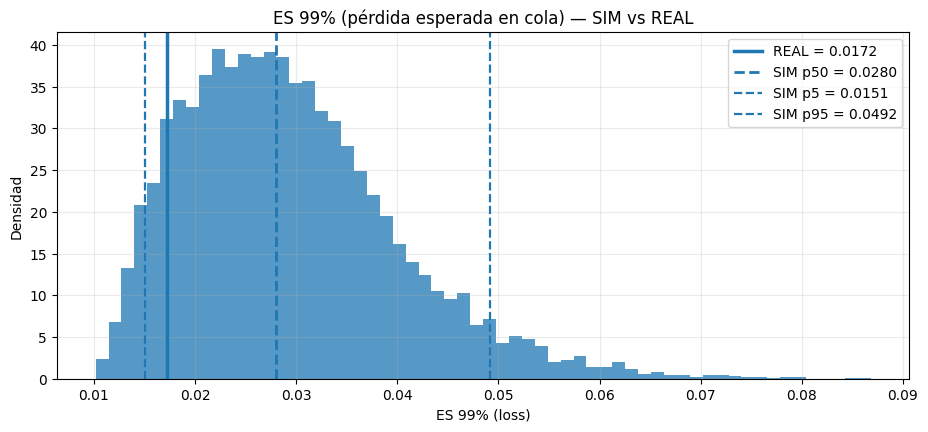

,REAL calm,REAL crisis,SIM calm,SIM crisis
Vol media activos (diaria),0.016219,0.023293,0.015851,0.022798
Correlación media offdiag,0.138074,0.321221,0.154229,0.307192
Extremos: #activos bajo q1 (prom.),0.181598,0.196429,0.179834,0.178990


,REAL crisis/calm,SIM crisis/calm
Vol ratio,1.436154,1.438265
Δ Corr media (crisis-calm),0.183147,0.152962
Δ Extremos (# activos),0.014831,-0.000844


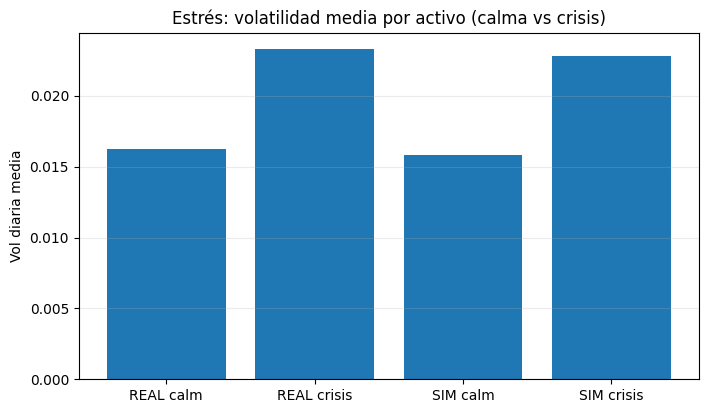

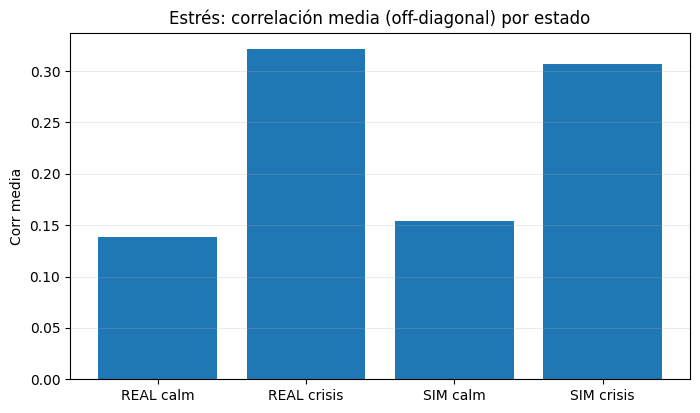

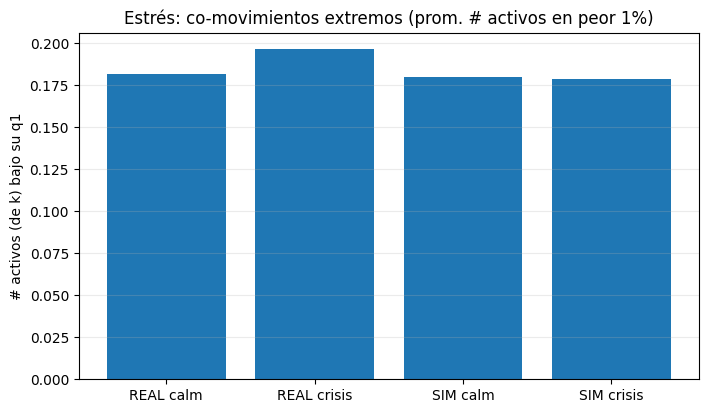

In [115]:
# ============================================================
# Reproducción de riesgo y dependencia (REAL vs SIM) + checks estrés
# ============================================================

crisis_state = int(crisis_state)
S = np.asarray(S)
port_ret_sim = np.asarray(port_ret_sim)      # (N, T)
port_ret_real = np.asarray(port_ret_real)    # (T,)

N, T = port_ret_sim.shape
if port_ret_real.shape[0] != T:
    raise ValueError(f"port_ret_real (len={len(port_ret_real)}) != T simulado ({T}). Revisa la ventana.")

ann = 252

# Universo (orden consistente con cópula)
if "calm_columns" in globals():
    assets = list(calm_columns)
elif "tickers_to_keep" in globals():
    assets = list(tickers_to_keep)
else:
    assets = list(wallet_returns.columns)

assets = [a for a in assets if a in wallet_returns.columns]
k = len(assets)

if nu_calm_corr.shape != (k,k) or nu_crisis_corr.shape != (k,k):
    raise ValueError(
        f"Dimensiones no cuadran: k={k}, nu_calm_corr={nu_calm_corr.shape}, nu_crisis_corr={nu_crisis_corr.shape}. "
        "Asegura que `assets` está en el mismo orden que se usó al calibrar la cópula."
    )

# -----------------------------
# 1) Funciones de métricas
# -----------------------------
def max_drawdown_from_returns(r: np.ndarray) -> float:
    """MDD sobre wealth (base 1) a partir de retornos aritméticos diarios."""
    r = np.asarray(r, dtype=float)
    w = np.empty(r.size + 1)
    w[0] = 1.0
    w[1:] = np.cumprod(1.0 + r)
    peak = np.maximum.accumulate(w)
    dd = (w / peak) - 1.0
    return float(dd.min())  # negativo (ej. -0.12 = -12%)

def var_es(r: np.ndarray, alpha: float = 0.01):
    """VaR y ES como pérdidas POSITIVAS. alpha=0.01 => VaR99/ES99."""
    r = np.asarray(r, dtype=float)
    q = np.quantile(r, alpha)
    var = -q
    es = -r[r <= q].mean() if np.any(r <= q) else np.nan
    return float(var), float(es), float(q)

def summarize(x: np.ndarray):
    x = np.asarray(x, dtype=float)
    return {
        "mean": float(np.nanmean(x)),
        "p5":  float(np.nanpercentile(x, 5)),
        "p50": float(np.nanpercentile(x, 50)),
        "p95": float(np.nanpercentile(x, 95)),
    }

# -----------------------------
# 2) Métricas de cartera: REAL
# -----------------------------
vol_d_real = float(np.std(port_ret_real, ddof=1))
vol_a_real = vol_d_real * np.sqrt(ann)
mdd_real = max_drawdown_from_returns(port_ret_real)
var99_real, es99_real, q01_real = var_es(port_ret_real, alpha=0.01)

# -----------------------------
# 3) Métricas de cartera: SIM (por trayectoria)
# -----------------------------
vol_d_sim = np.std(port_ret_sim, axis=1, ddof=1)
vol_a_sim = vol_d_sim * np.sqrt(ann)

# MDD por trayectoria (vectorizado)
wealth_sim = np.empty((N, T+1), dtype=float)
wealth_sim[:,0] = 1.0
wealth_sim[:,1:] = np.cumprod(1.0 + port_ret_sim, axis=1)

peak = np.maximum.accumulate(wealth_sim, axis=1)
dd = wealth_sim / peak - 1.0
mdd_sim = dd.min(axis=1)  # negativo

# VaR/ES por trayectoria (con T=126 es ruidoso, pero vale como distribución)
q01_sim = np.quantile(port_ret_sim, 0.01, axis=1)
var99_sim = -q01_sim
es99_sim = np.empty(N, dtype=float)
for i in range(N):
    mask = port_ret_sim[i] <= q01_sim[i]
    es99_sim[i] = -port_ret_sim[i, mask].mean() if np.any(mask) else np.nan

# Resumen
summary_tbl = pd.DataFrame({
    "REAL": [vol_d_real, vol_a_real, mdd_real, var99_real, es99_real],
    "SIM mean": [summarize(vol_d_sim)["mean"], summarize(vol_a_sim)["mean"], summarize(mdd_sim)["mean"],
                 summarize(var99_sim)["mean"], summarize(es99_sim)["mean"]],
    "SIM p5": [summarize(vol_d_sim)["p5"], summarize(vol_a_sim)["p5"], summarize(mdd_sim)["p5"],
               summarize(var99_sim)["p5"], summarize(es99_sim)["p5"]],
    "SIM p50": [summarize(vol_d_sim)["p50"], summarize(vol_a_sim)["p50"], summarize(mdd_sim)["p50"],
                summarize(var99_sim)["p50"], summarize(es99_sim)["p50"]],
    "SIM p95": [summarize(vol_d_sim)["p95"], summarize(vol_a_sim)["p95"], summarize(mdd_sim)["p95"],
                summarize(var99_sim)["p95"], summarize(es99_sim)["p95"]],
}, index=["Vol diaria","Vol anualizada","Max Drawdown","VaR 99% (loss)","ES 99% (loss)"])

display(summary_tbl)

# -----------------------------
# 4) Gráficos: distribución métricas SIM + línea REAL
# -----------------------------
def hist_compare(x, x_real, title, xlabel):
    x = np.asarray(x, float)
    plt.figure(figsize=(11,4.5))
    plt.hist(x, bins=60, density=True, alpha=0.75)
    plt.axvline(x_real, linewidth=2.5, label=f"REAL = {x_real:.4f}")
    p5,p50,p95 = np.percentile(x[np.isfinite(x)], [5,50,95])
    plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 = {p50:.4f}")
    plt.axvline(p5,  linestyle="--", linewidth=1.6, label=f"SIM p5 = {p5:.4f}")
    plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 = {p95:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

hist_compare(vol_d_sim, vol_d_real, "Volatilidad diaria — SIM vs REAL", "Vol diaria")
hist_compare(vol_a_sim, vol_a_real, "Volatilidad anualizada — SIM vs REAL", "Vol anualizada")
hist_compare(mdd_sim, mdd_real, "Máximo drawdown — SIM vs REAL", "MDD (negativo)")
hist_compare(var99_sim, var99_real, "VaR 99% (pérdida) — SIM vs REAL", "VaR 99% (loss)")
hist_compare(es99_sim, es99_real, "ES 99% (pérdida esperada en cola) — SIM vs REAL", "ES 99% (loss)")

# ============================================================
# 5) CHECKS de ESTRÉS: ¿sube vol? ¿cambian correlaciones? ¿más extremos?
#   REAL: por estados del HMM en el histórico completo
#   SIM : recalculamos stats por estado usando la misma cópula+marginales,
#         siguiendo la secuencia de estados S (sin guardar todo en memoria).
# ============================================================

# ----- REAL por estado (histórico completo) -----
logR_all = wallet_returns[assets].dropna(how="any")
states_all = wallet_crisis_prediction.reindex(logR_all.index, method="ffill").astype(int).values

calm_state = int(np.min([s for s in np.unique(states_all) if s != crisis_state])) if len(np.unique(states_all)) > 1 else 1-crisis_state

logR_calm = logR_all.iloc[states_all == calm_state].values
logR_cris = logR_all.iloc[states_all == crisis_state].values

arith_calm = np.expm1(logR_calm)
arith_cris = np.expm1(logR_cris)

vol_real_calm = np.std(arith_calm, axis=0, ddof=1)
vol_real_cris = np.std(arith_cris, axis=0, ddof=1)

corr_real_calm = np.corrcoef(arith_calm, rowvar=False)
corr_real_cris = np.corrcoef(arith_cris, rowvar=False)

def mean_offdiag(C):
    C = np.asarray(C, float)
    iu = np.triu_indices_from(C, k=1)
    return float(np.nanmean(C[iu]))

mean_corr_real_calm = mean_offdiag(corr_real_calm)
mean_corr_real_cris = mean_offdiag(corr_real_cris)

# co-movimientos extremos: nº medio de activos por día por debajo del 1% (por estado)
q1_real_calm = np.quantile(arith_calm, 0.01, axis=0)
q1_real_cris = np.quantile(arith_cris, 0.01, axis=0)
ext_real_calm = float((arith_calm <= q1_real_calm).sum(axis=1).mean()) if arith_calm.size else np.nan
ext_real_cris = float((arith_cris <= q1_real_cris).sum(axis=1).mean()) if arith_cris.size else np.nan

# ----- SIM por estado (re-sample eficiente siguiendo S) -----
# Marginales empíricas (log-returns) por estado para inverse-CDF
if "wallet_calm_returns" in globals() and "wallet_crisis_returns" in globals():
    calm_data = wallet_calm_returns[assets].dropna(how="any").values
    cris_data = wallet_crisis_returns[assets].dropna(how="any").values
else:
    calm_data = logR_all.iloc[states_all == calm_state].values
    cris_data = logR_all.iloc[states_all == crisis_state].values

sorted_calm = np.sort(calm_data, axis=0)
sorted_cris = np.sort(cris_data, axis=0)

def inv_ecdf(U: np.ndarray, sorted_vals: np.ndarray) -> np.ndarray:
    """Inverse empirical CDF via sorted columns (linear interp)."""
    n = sorted_vals.shape[0]
    x = U * (n - 1)
    i0 = np.floor(x).astype(int)
    i1 = np.minimum(i0 + 1, n - 1)
    w = x - i0
    v0 = np.take_along_axis(sorted_vals, i0, axis=0)
    v1 = np.take_along_axis(sorted_vals, i1, axis=0)
    return v0 + (v1 - v0) * w

import scipy.stats as sps  # <-- usa otro alias para no pisarlo

def sample_t_copula_U(m, Rho, nu, rng):
    """Muestrea U de una t-cópula (usa `k` global)."""
    Rho = np.asarray(Rho, float)
    L = np.linalg.cholesky(Rho)

    # usa k global (definido antes como len(assets))
    g = rng.standard_normal((m, k)) @ L.T
    w = rng.chisquare(df=nu, size=m)
    z = g / np.sqrt(w[:, None] / nu)

    U = sps.t.cdf(z, df=nu)
    eps = 1e-12
    return np.clip(U, eps, 1 - eps)

rng = np.random.default_rng(globals().get("SEED", 123))

# Agregadores por estado para media/cov
agg = {
    calm_state: {"n":0, "sum":np.zeros(k), "sumsq":np.zeros(k), "sumouter":np.zeros((k,k)),
                "ext_hits":0.0, "obs":0},
    crisis_state: {"n":0, "sum":np.zeros(k), "sumsq":np.zeros(k), "sumouter":np.zeros((k,k)),
                   "ext_hits":0.0, "obs":0},
}

# thresholds de extremos en SIM: usar los q1 reales por estado (comparación coherente)
q1_sim_calm = q1_real_calm
q1_sim_cris = q1_real_cris

for t in range(T):
    s_t = S[:, t]
    for st_ in [calm_state, crisis_state]:
        idx = np.where(s_t == st_)[0]
        m = idx.size
        if m == 0:
            continue

        if st_ == crisis_state:
            nu = int(crisis_nu); Rho = nu_crisis_corr; sorted_vals = sorted_cris; q1 = q1_sim_cris
        else:
            nu = int(calm_nu);   Rho = nu_calm_corr;   sorted_vals = sorted_calm; q1 = q1_sim_calm

        U = sample_t_copula_U(m, Rho, nu, rng)                 # (m,k)
        logR = inv_ecdf(U, sorted_vals)                        # (m,k) log-returns
        arR  = np.expm1(logR)                                  # (m,k) arithmetic

        A = agg[st_]
        A["n"] += m
        A["sum"] += arR.sum(axis=0)
        A["sumsq"] += (arR**2).sum(axis=0)
        A["sumouter"] += arR.T @ arR

        # extremos: nº medio de activos por observación que caen bajo q1
        A["ext_hits"] += float((arR <= q1).sum())  # cuenta total de "hits" (obs*assets)
        A["obs"] += m

def finalize_state(A):
    n = A["n"]
    mu = A["sum"] / n
    cov = (A["sumouter"] / n) - np.outer(mu, mu)
    sd = np.sqrt(np.clip(np.diag(cov), 1e-18, None))
    corr = cov / np.outer(sd, sd)
    vol = sd
    mean_corr = mean_offdiag(corr)
    ext_avg_assets = A["ext_hits"] / A["obs"] if A["obs"] > 0 else np.nan
    return mu, vol, corr, mean_corr, ext_avg_assets

mu_sim_calm, vol_sim_calm, corr_sim_calm, mean_corr_sim_calm, ext_sim_calm = finalize_state(agg[calm_state])
mu_sim_cris, vol_sim_cris, corr_sim_cris, mean_corr_sim_cris, ext_sim_cris = finalize_state(agg[crisis_state])

# ----- Report resumen estrés -----
stress_tbl = pd.DataFrame({
    "REAL calm": [float(np.mean(vol_real_calm)), mean_corr_real_calm, ext_real_calm],
    "REAL crisis": [float(np.mean(vol_real_cris)), mean_corr_real_cris, ext_real_cris],
    "SIM calm": [float(np.mean(vol_sim_calm)), mean_corr_sim_calm, ext_sim_calm],
    "SIM crisis": [float(np.mean(vol_sim_cris)), mean_corr_sim_cris, ext_sim_cris],
}, index=["Vol media activos (diaria)","Correlación media offdiag","Extremos: #activos bajo q1 (prom.)"])

display(stress_tbl)

# Ratios crisis/calma (deberían ser >1 en vol y normalmente subir corr/colas)
ratio_tbl = pd.DataFrame({
    "REAL crisis/calm": [
        float(np.mean(vol_real_cris) / np.mean(vol_real_calm)),
        float(mean_corr_real_cris - mean_corr_real_calm),
        float(ext_real_cris - ext_real_calm)
    ],
    "SIM crisis/calm": [
        float(np.mean(vol_sim_cris) / np.mean(vol_sim_calm)),
        float(mean_corr_sim_cris - mean_corr_sim_calm),
        float(ext_sim_cris - ext_sim_calm)
    ]
}, index=["Vol ratio","Δ Corr media (crisis-calm)","Δ Extremos (# activos)"])

display(ratio_tbl)

# ----- Gráficos estrés (fáciles de leer) -----
# 1) Vol media por estado
plt.figure(figsize=(8,4.5))
plt.bar(["REAL calm","REAL crisis","SIM calm","SIM crisis"],
        [np.mean(vol_real_calm), np.mean(vol_real_cris), np.mean(vol_sim_calm), np.mean(vol_sim_cris)])
plt.title("Estrés: volatilidad media por activo (calma vs crisis)")
plt.ylabel("Vol diaria media")
plt.grid(True, axis="y", alpha=0.25)
plt.show()

# 2) Corr media offdiag
plt.figure(figsize=(8,4.5))
plt.bar(["REAL calm","REAL crisis","SIM calm","SIM crisis"],
        [mean_corr_real_calm, mean_corr_real_cris, mean_corr_sim_calm, mean_corr_sim_cris])
plt.title("Estrés: correlación media (off-diagonal) por estado")
plt.ylabel("Corr media")
plt.grid(True, axis="y", alpha=0.25)
plt.show()

# 3) Co-movimientos extremos
plt.figure(figsize=(8,4.5))
plt.bar(["REAL calm","REAL crisis","SIM calm","SIM crisis"],
        [ext_real_calm, ext_real_cris, ext_sim_calm, ext_sim_cris])
plt.title("Estrés: co-movimientos extremos (prom. # activos en peor 1%)")
plt.ylabel("# activos (de k) bajo su q1")
plt.grid(True, axis="y", alpha=0.25)
plt.show()
